# Postprocessing for mizuRoute global Hanasaki simulations comparison with reservoir observations
postprocessing from Cheyenne - global simulations with HDMA topology

Inne Vanderkelen - March 2021

**TO DO:**
* Make it work with non daily observations (more reservoir obs)
* Interpretation of metrics

In [1]:
# import modules
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import os
import utils
import seaborn as sns
import hydroeval as he
import warnings
import pickle

warnings.filterwarnings('ignore')

# plot settings
utils.set_plot_param()

### Settings

In [2]:
# flags

# Load full mizuroute simulations, when false: load saved pickles
flag_load_simulations = False

# plot individual reservoir simulations
plot_ind_reservoirs = False

# plot inflow bias
plot_inflow = True

# plot naturalised flows on inflow bias plot
plot_natflow = True

In [3]:
# define directories

# model directory
outdir = '/glade/work/ivanderk/mizuRoute_global/route/'

# current working directory
scriptsdir = os.getcwd() + '/'

# observations dir
obsdir = scriptsdir + 'lake_models_python/Hanasaki/observations/'

# give simulation name
#cases = ['natlake', 'natlake_wb_both']#,'natlake_bc', 'H06_bc', 'H06_noirrig_bc' ] #'H06_bc_obsscaled' 'natlake', 'H06_noirrig_bc',['nolake', 'natlake', 'H06', ]#, 'H06_noirrig'] #'H06_noirrig'
#cases = ['natlake', 'nolake_bc','natlake_bc', 'H06_bc', 'H06_noirrig_bc' ] #'H06_bc_obsscaled' 'natlake', 'H06_noirrig_bc',['nolake', 'natlake', 'H06', ]#, 'H06_noirrig'] #'H06_noirrig'
cases = ['natlake', 'H06', 'nolake']
cases_simple = [ 'natlake_bc', 'H06_bc',  'nolake_bc',  'H06_noirrig'] # 'natlake',,['nolake', 'natlake', 'H06']
cases_longname = [ 'natlake_bc', 'Hanasaki bc', 'no lakes'] # 'natlake', 'Hanasaki no irrig bc',  ['no lakes', 'Döll', 'Hanasaki', 'Hanasaki no irrig' ]#, 'H06_noirrig']
colors = [ 'skyblue','yellowgreen', 'coral','gold', 'pink' ]

#cases_bc = [ 'natlake_bc', 'H06_bc',  'nolake_bc', 'H06_noirrig_bc']
#cases_longname_bc = ['Döll', 'Hanasaki', 'Hanasaki_noirrig', 'nolake']
cases_longname_dict=  {'natlake':'NAT','nolake':'NOLAKES', 'H06':'DAM','H06_noirrig':'DAM_NOIRRIG', 'nolake_bc':'NOLAKES'}
colors_dict = {'natlake':'yellowgreen','nolake':'skyblue', 'H06':'coral','H06_noirrig':'gold','nolake_bc':'skyblue',}


#cases = ['natlake', 'natlake_bc_delta','natlake_bc']#, 'H06_bc_delta']#, 'H06_noirrig_bc_delta', 'nolake_bc_delta' ] #'H06_bc_obsscaled' 'natlake', 'H06_noirrig_bc',['nolake', 'natlake', 'H06', ]#, 'H06_noirrig'] #'H06_noirrig'
#colors_dict = {'natlake_bc':'orange', 'natlake':'pink','nolake_bc_delta':'skyblue', 'H06_bc_delta':'coral', 'H06_noirrig_bc_delta':'gold', 'natlake_bc_delta':'yellowgreen', 'natlake_wb_both': 'blue'}
#cases_longname_dict=  {'natlake_bc': 'NAT QUANT', 'natlake':'NAT','H06_bc':'Hanasaki','nolake_bc_delta':'no lake', 'H06_bc_delta':'Hanasaki', 'H06_noirrig_bc_delta':'Hanasaki no irrig', 'natlake_bc_delta':'NAT DELTA', 'natlake_wb_both' : 'wb'}


# simulation years
nspinup = 2 # number of spin up years 
start_year = 1979 + nspinup
end_year = 2000

# open topology 
ntopo = xr.open_dataset(outdir+'ancillary_data/ntopo_hdma_mod.reorder_lake_H06.nc')

# get observations metadata
df_meta = pd.read_csv(obsdir+'reservoirs_metadata.csv')

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

panel_labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.', 'h.', 'i.', 'j.', 'k.', 'l.', 'm.', 'n.', 'o.', 'p.', 'q.', 'r.', 's.', 't.', 'u.', 'v.', 'w.']


names_dict = {'Ghost':'Ghost', 'EB_campbell':'E.B. Campbell', 'Dickson': 'Dickson', 'Palisades':'Palisades', 'charavak':'Charavak',
       'American_falls':'American Falls', 'Oldman':'Oldman', 'St_marry':'St. Mary', 'Nurek': 'Nurek', 'Yellowtail':'Yellowtail',
       'Oroville':'Oroville', 'Seminoe':'Seminoe', 'Navajo':'Navajo', 'Falcon':'Falcon', 'Oahe':'Oahe', 'Toktogul':'Toktogul',
       'Garrison':'Garrison', 'Trinity':'Trinity', 'Glen_canyon': 'Glen Canyon', 'Sirikit':'Sirikit', 'Flaming_gorge': 'Flaming Gorge',
       'Fort_peck': 'Fort Peck', 'Amistad': 'Amistad', 'Bhumibol': 'Bhumibol', 'High_aswan': 'High Aswan', 'Bennett': 'W.A.C. Bennet' }

panellabels_conus_dict = {'Ghost':'s', 'EB_campbell':'g','Palisades':'r', 'American_falls':'q', 'Oldman':'b', 'St_marry':'c', 'Yellowtail':'d',
       'Oroville':'o', 'Seminoe':'f', 'Navajo':'l', 'Falcon':'k', 'Oahe':'i', 'Garrison':'h', 'Trinity':'p', 'Glen_canyon': 'm', 'Flaming_gorge': 'n',
       'Fort_peck': 'e', 'Amistad': 'j', }

In [4]:
# Settings
# specify which reservoirs to look at
#names = ['Bhumiboi', 'Sirikit' , 'Glen_canyon', 'Palisades', 'High_aswan', 'Dickson'] #, 'Waterton'] 
#names = ['American_falls', 'Amistad', 'Bennett', 'charavak', 'EB_campbell', 'Falcon', 'Flaming_gorge', 'Fort_peck', 'Fort_randall', 'Garrison', 'Ghost', 'Navajo', 'Nurek', 'Oahe', 'Oroville', 'Semione', 'St_marry', 'Toktogul', 'Trinity', 'Yellowtail']
# not working
# names = ['Bennett', 'charavak', 'EB_campbell', 'Ghost', 'Nurek', 'Oroville', 'St_marry', 'Toktogul']

# only keep reservoirs which are on HDMA river network
df_meta = df_meta.loc[df_meta['pfaf_hdma_10km'].notnull()]
names = df_meta['name'].values
names = np.delete(names,np.where(names=='Fort_randall'))
#names = np.delete(names,np.where(names=='Fort_peck'))

# drop Frot Randall
# get their pfafs as list 
res_pfafs = df_meta.loc[df_meta['name'].isin(names),'pfaf_hdma_10km'].values


## 1. Load simulation for all reservoir segments

In [5]:
%%time

if flag_load_simulations: 
    # load mizuroute simulations for different cases

    # create mask with segids for reservoir reaches
    mask_stations = ntopo.PFAF.astype(int).isin(res_pfafs.astype(int))

    #initialise empty dictionary for storing mizuroute simulations
    ds_sim_dict = {}

    for case in cases: 
        print(case)
        # laod all years and append into one dataset with storage, inflow and outflow
        ds_res_year_all =  []
        for year in range(start_year,end_year+1):
            print('Loading year '+str(year)+'\r')
            # Open simulation for one year
            ds = xr.open_dataset(outdir+"output/"+case+".mizuRoute.h."+str(year)+"-01-01-00000.nc")

            # extract reservoir outflow and volume
            ds_res_year = ds['IRFroutedRunoff'].where(mask_stations).to_dataset(name='outflow')
            ds_res_year['storage'] = ds['IRFlakeVol'].where(mask_stations)
            ds_res_year['inflow'] = ds['sumUpstreamRunoff'].where(mask_stations)

            ds_res_year_all.append(ds_res_year)

        ds_mod = xr.concat(ds_res_year_all, dim='time')
        ds_sim_dict[case] = ds_mod

    # extract individual reservoirs from simulations for all cases
    # save as dict per reservoir, per case as dataframe

    df_mod_dict = {}

    for i,reservoir_name in enumerate(names):

        # find reservoir index
        res_pfaf = res_pfafs[i]
        idx = np.where(ntopo.PFAF.values.astype(np.int) == int(res_pfaf))[0][0]
        res_dict = {}
        # extract reservoir from different simulations
        for case in cases:  

            res_dict[case] = ds_sim_dict[case].sel(seg=idx).to_dataframe()
            # convert calendar to datetime
            res_dict[case].index = res_dict[case].index.to_datetimeindex()

        df_mod_dict[reservoir_name] = res_dict

    with open('natlake_H06_nolake.pickle', 'wb') as handle:
        pickle.dump(df_mod_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

else: 
    with open('natlake_H06_nolake.pickle', 'rb') as handle:
        df_mod_dict = pickle.load(handle)

    
        

CPU times: user 26.1 ms, sys: 9.43 ms, total: 35.5 ms
Wall time: 111 ms


## 2. Compare MizuRoute output for reservoir with reservoir observations

In [6]:
def set_plot_param():
    """Set my own customized plotting parameters"""
    
    import matplotlib as mpl
    mpl.rc('xtick',labelsize=12)
    mpl.rc('ytick',labelsize=12)
    mpl.rc('axes',titlesize=16)
    mpl.rc('axes',labelsize=12)
    mpl.rc('axes',edgecolor='grey')
    mpl.rc('grid', color='lightgray')
    mpl.rc('axes',labelcolor='dimgrey')
    mpl.rc('xtick',color='dimgrey')
    mpl.rc('ytick',color='dimgrey')
    mpl.rc('text',color='dimgrey')
    mpl.rc('legend',fontsize=12, frameon=False)


set_plot_param()

In [7]:
kge_dict = {}
pearson_dict = {}
alpha_dict = {}
beta_dict = {}
nse_dict = {}
rmse_dict = {}
mare_dict = {}
pbias_dict = {}

res_info = {}

res_dict = {}
obs_dict = {}
for i,reservoir_name in enumerate(names):
   
    ### get simulations for reservoir
    #df_res_dict = df_mod_dict[reservoir_name]    
    
   ### load observation


    # get pfaf for reservoir
    df_meta = pd.read_csv(obsdir+'reservoirs_metadata.csv')
    res_pfaf = df_meta.loc[df_meta['name']==reservoir_name,'pfaf_hdma_10km']

    if reservoir_name == 'Bhumiboi': 
    
        res_pfaf = df_meta.loc[df_meta['name']=='Bhumibol','pfaf_hdma_10km']
        df_res_dict = df_mod_dict[reservoir_name]    
    #elif reservoir_name == 'Seminoe': 
     #   res_pfaf = df_meta.loc[df_meta['name']=='Seminoe','pfaf_hdma_10km']
      #  df_res_dict = df_mod_dict['Semione']    
    else: 
        df_res_dict = df_mod_dict[reservoir_name]    

    
   # read observations
    df_obs = pd.read_csv(obsdir+'res_info_out_'+reservoir_name+'.csv').rename(columns={'timed':'time','stoobs': 'storage'})
    df_obs.index = pd.to_datetime(df_obs.time)
    df_obs.index = df_obs.index.normalize() # turn observations of 12h to 00h 

    
    # exclude leap days because MizuRoute does not account for leap days
    df_obs = df_obs[df_obs.index.strftime('%m-%m') != '02-29'] 

    # get simulation period from loaded simulation
    sim_period = df_res_dict[cases[0]]['outflow'].index
    # get obs and mod overlapping timeseries
    period_overlap = sim_period.intersection(df_obs.index)
    
    # mask observations for overlapping period
    df_obs = df_obs.loc[df_obs.index.isin(period_overlap)]


    
    # only continue if there are overlapping observations and simulations
    if df_obs.empty: print(reservoir_name+' has no observations in simulation period')
    else: 
        # mask simulation for overlapping period
        df_obs_dict = {}
        for case in cases: 
            period_overlap_case = df_res_dict[case]['outflow'].index.intersection(df_obs.index)
            df_obs_dict[case] = df_obs.loc[df_obs.index.isin(period_overlap_case)]
            df_res_dict[case] = df_res_dict[case].loc[df_res_dict[case].index.isin(period_overlap_case)]
        
        # determine timestep of observations (to account for monthly)
        timestep = 'daily' if (df_obs.index[1] - df_obs.index[0]).days == 1 else 'monthly'

        res_dict[reservoir_name] = df_res_dict
        obs_dict[reservoir_name] = df_obs_dict
        ### get reservoir categorisation

        ntopo_res = ntopo.where(ntopo.PFAF.astype(float) == res_pfaf.values, drop=True)
        max_storage = ntopo_res['H06_Smax'].values
        inflow_seas = []
        for month in months: inflow_seas.append(ntopo_res['H06_I_'+month].values[0])
        inflow_mean = np.mean(inflow_seas) * 86400 * 365 # m/year
        c = max_storage/inflow_mean
        if c>0.5: res_size='multi-year'
        else: res_size='within-a-year'

        if ntopo_res['H06_purpose'] ==1: res_type='irrigation'
        else: res_type='non-irrigation'

        # save information on reservoir
        res_info[reservoir_name] = {'purpose': res_type, 'size': res_size, 'Smax' : max_storage}
            
        ### calculate scores for variables 
        kge_res_dict = {}
        pearson_res_dict = {}
        alpha_res_dict = {}
        beta_res_dict = {}

        nse_res_dict = {}
        rmse_res_dict = {}
        mare_res_dict = {}
        pbias_res_dict = {}
        
        for case in cases: 
            
            kge_res_dict_var = {}
            pearson_res_dict_var = {}
            alpha_res_dict_var = {}
            beta_res_dict_var = {}

            nse_res_dict_var = {}
            rmse_res_dict_var = {}
            mare_res_dict_var = {}
            pbias_res_dict_var = {}
            
            for variable in ['outflow','storage']: 

                (kge_res_dict_var[variable], pearson_res_dict_var[variable], alpha_res_dict_var[variable], beta_res_dict_var[variable])   = he.evaluator(he.kge,df_obs_dict[case][variable].values,df_res_dict[case][variable].values)
                nse_res_dict_var[variable]   = he.evaluator(he.nse,df_obs_dict[case][variable].values,df_res_dict[case][variable].values)[0]
                rmse_res_dict_var[variable]  = he.evaluator(he.rmse,df_obs_dict[case][variable].values,df_res_dict[case][variable].values)[0]
                mare_res_dict_var[variable]  = he.evaluator(he.mare,df_obs_dict[case][variable].values,df_res_dict[case][variable].values)[0]
                pbias_res_dict_var[variable] = he.evaluator(he.pbias,df_obs_dict[case][variable].values,df_res_dict[case][variable].values)[0]

            kge_res_dict[case]     = kge_res_dict_var
            pearson_res_dict[case] = pearson_res_dict_var
            alpha_res_dict[case]   = alpha_res_dict_var
            beta_res_dict[case]    = beta_res_dict_var

            nse_res_dict[case]   = nse_res_dict_var
            rmse_res_dict[case]  = rmse_res_dict_var
            mare_res_dict[case]  = mare_res_dict_var
            pbias_res_dict[case] = pbias_res_dict_var

            kge_dict[reservoir_name] = kge_res_dict
            alpha_dict[reservoir_name] = alpha_res_dict
            beta_dict[reservoir_name] = beta_res_dict
            pearson_dict[reservoir_name] = pearson_res_dict

            nse_dict[reservoir_name] = nse_res_dict
            rmse_dict[reservoir_name] = rmse_res_dict
            mare_dict[reservoir_name] = mare_res_dict
            pbias_dict[reservoir_name] = pbias_res_dict


        ########
        # do plotting
        
        if plot_ind_reservoirs: 
            fig, axes = plt.subplots(3,2, figsize = (10,8), gridspec_kw={
                                   'width_ratios': [2, 1],
                                   'height_ratios': [1, 1, 1]})

            for n,variable in enumerate( ['inflow','outflow','storage']):
                for j, case in enumerate(cases):                      
                # plot timeseries
                    axes[n][0].plot(df_res_dict[case].index,df_res_dict[case][variable], label=cases_longname_dict[case], color=colors_dict[case], alpha=0.7)

                    # plot obs only once (not for every case)
                    if j == 0: axes[n][0].plot(df_obs.index, df_obs[variable], color="gray", label = "observations")

                    if variable == 'storage': 
                        ylabel = 'Storage [m³]'
                    elif variable == 'inflow' :
                        ylabel  =  'Inflow [m³/s]'
                    else: ylabel='Outflow [m³/s]'

                    axes[n][0].set_ylabel(ylabel); 
                    axes[n][0].set_xlim([df_res_dict[case].index.min(),df_res_dict[case].index.max()]); 

                    import matplotlib.dates as mdates
                    myFmt = mdates.DateFormatter('%Y')
                    axes[n][0].xaxis.set_major_formatter(myFmt)
                    #axes[n][0].grid()

                    # plot seasonal cycle 
                    if timestep == 'daily': 
                        df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.dayofyear).mean()
                        df_obs_seasonal = df_obs[variable].groupby(df_obs[variable].index.dayofyear).mean()

                        axes[n][1].set_xticks(np.linspace(15,380,13)[:-1])
                        axes[n][1].set_xlim([0,366])
                    elif timestep == 'monthly': 
                        df_res_seasonal = df_res_dict[case][variable].groupby(df_res_dict[case][variable].index.month).mean()
                        df_obs_seasonal = df_obs[variable].groupby(df_obs[variable].index.month).mean()
                        axes[n][1].set_xticks(np.linspace(1.5,12.5,12))
                        axes[n][1].set_xlim([1,12])

                    axes[n][1].plot(df_res_seasonal.index,df_res_seasonal,label=cases_longname_dict[case], color=colors_dict[case])
                    axes[n][1].plot(df_obs_seasonal.index, df_obs_seasonal, color="gray", label = "observations")
                    axes[n][1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
                    axes[n][1].set_title(variable.title(), loc='right'); 

                #axes[n][1].grid()


            axes[n][0].legend(bbox_to_anchor=(-0, -0.05, 1., -0.152), loc='upper left',
                   ncol=2, mode="expand", borderaxespad=0.); 

            fig.suptitle(reservoir_name + ' ('+res_type+ ', '+res_size+')', fontsize=16,x=0.15, y= 0.99)
            fig.tight_layout()
            fig.savefig(scriptsdir+'plots/resobs_clm/'+reservoir_name+'.png')

            if res_type == 'irrigation': 
                fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
                demand_seas = []
                for month in months: demand_seas.append(ntopo_res['H06_D_'+month].values[0])
                ax1.plot(np.arange(0,12), demand_seas)
                ax1.set_xticks(np.arange(0,12))
                ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
                ax1.set_xlim([0,11])
                ax1.set_title('Prescribed demand seasonality', loc='right', fontsize=14)
                ax1.set_ylabel('[m³/s]')

                ax2.plot(np.arange(0,12), inflow_seas)
                ax2.set_xticks(np.arange(0,12))
                ax2.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
                ax2.set_xlim([0,11])
                ax2.set_title('Prescribed inflow seasonality', loc='right', fontsize=14)
                ax2.set_ylabel('[m³/s]')
                fig.tight_layout()
                fig.savefig(scriptsdir+'plots/resobs_clm/prescribed_seasonality/'+reservoir_name+'.png')


Bennett has no observations in simulation period
charavak has no observations in simulation period
Dickson has no observations in simulation period
Nurek has no observations in simulation period
Toktogul has no observations in simulation period


## Get naturalised flow reconstructions

In [8]:
reservoirs_natflow = ['American_falls', 'Palisades', 'Oroville', 'Trinity', 'Flaming_gorge', 'Glen_canyon', 'Navajo']
dict_natflow = {}

for res_natflow  in reservoirs_natflow: 
    ds_natflow = pd.read_csv('/glade/work/ivanderk/data/natflow/nat_streamflow_processed/natflow_m3persec_monthly_'+res_natflow+'.csv')
    ds_natflow = ds_natflow.set_index(pd.to_datetime(ds_natflow['time']))

    
    # find overlapping period
    period_overlap = obs_dict[res_natflow][case].index.intersection(ds_natflow.index)
    ds_natflow_overlap = ds_natflow.loc[ds_natflow.index.isin(period_overlap)]
    
    dict_natflow[res_natflow] = ds_natflow_overlap


### plot naturalised flow reservoirs

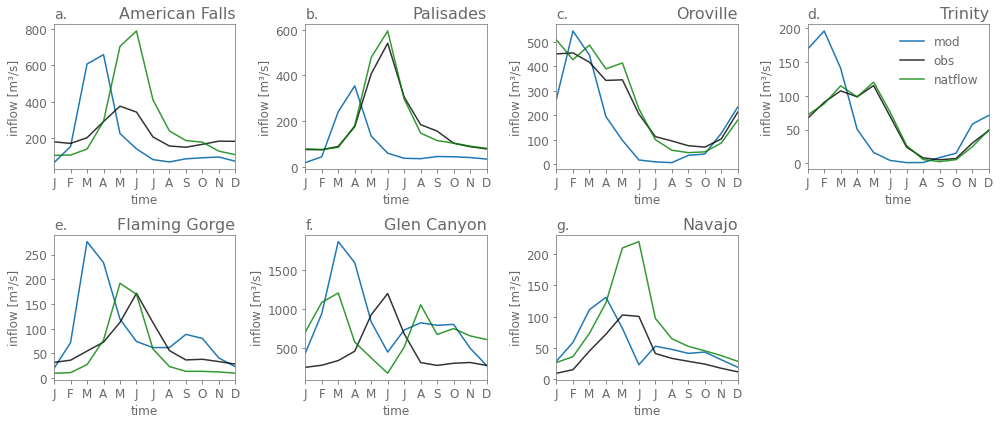

In [18]:
if plot_inflow: 

    case='natlake'
    variable='inflow'
    fig, axes = plt.subplots(2,4,figsize=(14,6))
    ax = axes.flatten()
    cases_toplot = ['natlake']

    cases_inflow = ['simulation']


    for i,reservoir_name in enumerate(reservoirs_natflow): 


        for n, case in enumerate(cases_toplot):

            df_res_seasonal = df_mod_dict[reservoir_name][case][variable].groupby(df_mod_dict[reservoir_name][case][variable].index.month).mean()
            df_res_seasonal.plot(ax=ax[i],  label='mod')

        df_obs_seasonal = obs_dict[reservoir_name]['natlake'][variable].groupby(obs_dict[reservoir_name]['natlake'][variable].index.month).mean()
        df_obs_seasonal.plot(ax=ax[i], label='obs', color='k', alpha=0.8)
        
        if plot_natflow: 
            if reservoir_name in reservoirs_natflow: 
                df_natflow = dict_natflow[reservoir_name].groupby(dict_natflow[reservoir_name].index.month).mean()
                df_natflow.plot(ax=ax[i], label='natflow', color='g', alpha=0.8, legend=False)            

        if plot_natflow and reservoir_name =='Trinity': 
            ax[i].legend()
            #ax[i].set_ylim([0,1000])    
            
        ax[i].set_xticks(np.arange(0,13))
        ax[i].set_xlim([1,12])
        ax[i].set_xticklabels(['','J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        ax[i].set_ylabel('inflow [m³/s]')
        """
        if df_meta['has_upstream_solved'].loc[df_meta['name']==reservoir_name].values[0] > 0: 
            upstream_text = 'res upstream'
        else:
            upstream_text = 'no res upstream'
            """
        ax[i].set_title(names_dict[reservoir_name], loc='right')
        ax[i].text(0, 1.04, panel_labels[i], color='dimgrey', fontsize=14, transform=ax[i].transAxes );

    for x in ax[i+1:]: 
        x.set_axis_off()

    fig.tight_layout()
    
    fig.savefig(scriptsdir+'plots/inflow_bias_only_natflow.png', bbox_inches="tight")


## plot inflow seasonality

In [102]:
for i,reservoir_name in enumerate(names): 


    if df_meta['has_upstream_solved'].loc[df_meta['name']==reservoir_name].values[0] > 0: 
            upstream_text = 'res upstream'
    else:
            upstream_text = 'no res upstream'
# manually checked reservoirs with no reservoirs upstream and included in global mizuRoute simulations: Trinity, Navajo, Oldman, Seminoe, Sirikit and St-Mary

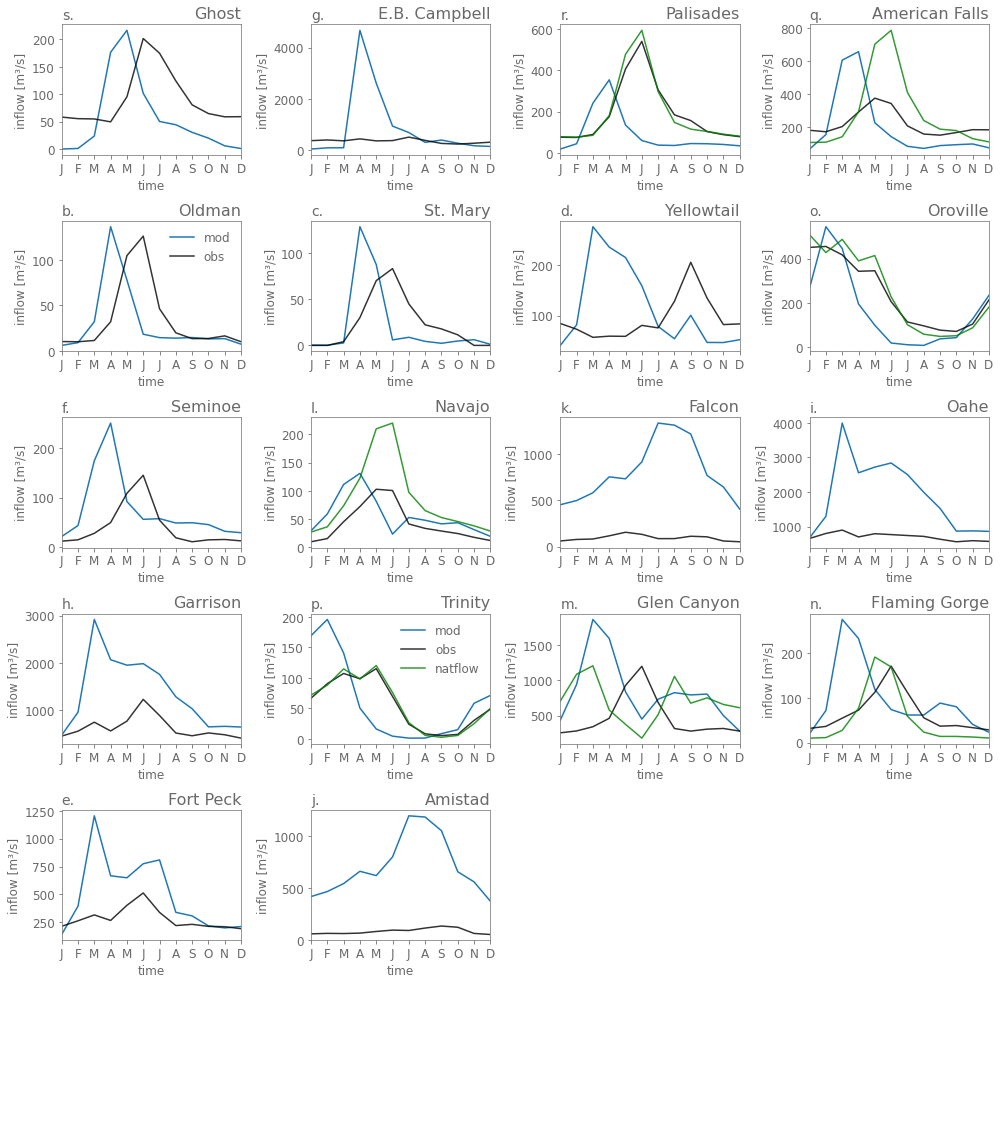

In [103]:
if plot_inflow: 

    case='natlake'
    variable='inflow'
    fig, axes = plt.subplots(6,4,figsize=(14,16))
    ax = axes.flatten()
    cases_toplot = ['natlake']

    cases_inflow = ['simulation']


    conus_res = ['Ghost', 'EB_campbell','Palisades', 'American_falls', 'Oldman', 'St_marry', 'Yellowtail',
           'Oroville','Seminoe', 'Navajo', 'Falcon', 'Oahe', 'Garrison', 'Trinity', 'Glen_canyon', 'Flaming_gorge',
           'Fort_peck', 'Amistad']

    for i,reservoir_name in enumerate(conus_res): 


        for n, case in enumerate(cases_toplot):

            df_res_seasonal = df_mod_dict[reservoir_name][case][variable].groupby(df_mod_dict[reservoir_name][case][variable].index.month).mean()
            df_res_seasonal.plot(ax=ax[i],  label='mod')

        df_obs_seasonal = obs_dict[reservoir_name]['natlake'][variable].groupby(obs_dict[reservoir_name]['natlake'][variable].index.month).mean()
        df_obs_seasonal.plot(ax=ax[i], label='obs', color='k', alpha=0.8)
        
        if plot_natflow: 
            if reservoir_name in reservoirs_natflow: 
                df_natflow = dict_natflow[reservoir_name].groupby(dict_natflow[reservoir_name].index.month).mean()
                df_natflow.plot(ax=ax[i], label='natflow', color='g', alpha=0.8, legend=False)            

        if reservoir_name =='Oldman': 
            ax[i].legend()
            #ax[i].set_ylim([0,1000])
        if plot_natflow and reservoir_name =='Trinity': 
            ax[i].legend()
            #ax[i].set_ylim([0,1000])    
            
        ax[i].set_xticks(np.arange(0,13))
        ax[i].set_xlim([1,12])
        ax[i].set_xticklabels(['','J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
        ax[i].set_ylabel('inflow [m³/s]')
        """
        if df_meta['has_upstream_solved'].loc[df_meta['name']==reservoir_name].values[0] > 0: 
            upstream_text = 'res upstream'
        else:
            upstream_text = 'no res upstream'
            """
        ax[i].set_title(names_dict[reservoir_name], loc='right')
        ax[i].text(0, 1.04, panellabels_conus_dict[reservoir_name]+'.', color='dimgrey', fontsize=14, transform=ax[i].transAxes );

    for x in ax[i+1:]: 
        x.set_axis_off()

    fig.tight_layout()
    if plot_natflow: 
        fig.savefig(scriptsdir+'plots/inflow_bias_natflow.png', bbox_inches="tight")
    else: 
        fig.savefig(scriptsdir+'plots/inflow_bias.png', bbox_inches="tight")


In [99]:
# get max bias values
res = ['Oahe', 'Garrison', 'Falcon', 'Amistad']

for i,reservoir_name in enumerate(res): 

    df_res_seasonal = df_mod_dict[reservoir_name]['H06'][variable].groupby(df_mod_dict[reservoir_name][case][variable].index.month).mean()

    df_obs_seasonal = obs_dict[reservoir_name]['natlake'][variable].groupby(obs_dict[reservoir_name]['natlake'][variable].index.month).mean()

    bias = (df_res_seasonal - df_obs_seasonal)/df_obs_seasonal * 100
    bias_max = bias.max()
    print(reservoir_name)
    print(str(np.round(bias_max))+ ' %')
    


Oahe
344.0 %
Garrison
294.0 %
Falcon
1434.0 %
Amistad
1224.0 %


## make metrics plots for outflow

In [14]:
# sort reservoirs 

# load capacity ratio per reservoir
df_c = pd.read_csv(scriptsdir+'results_resobs_pythoncode/capacity_ratio.csv')
names_sorted = df_c.sort_values(by='c').reset_index(drop=True).drop(columns='c')
names_sorted.columns =['name']
names_sorted['order'] = np.arange(0,len(names_sorted))


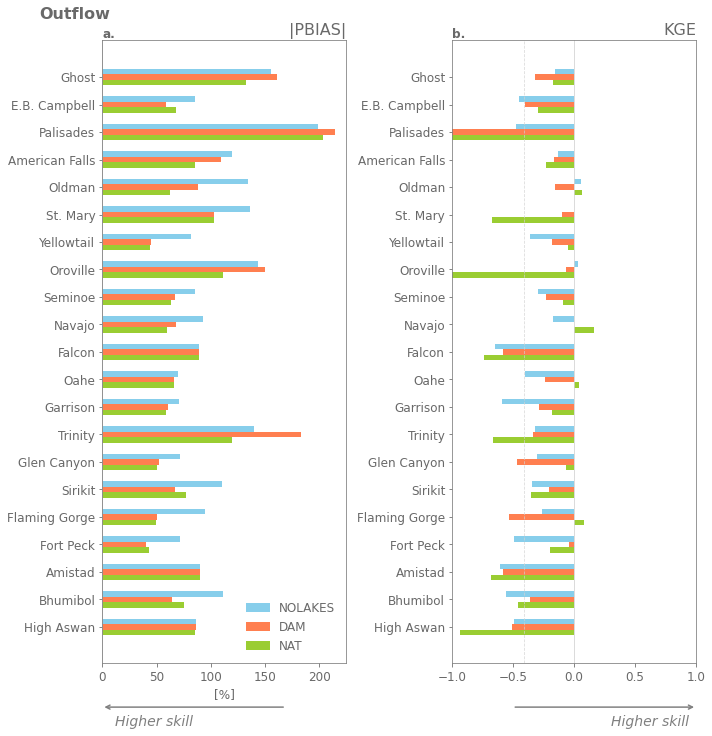

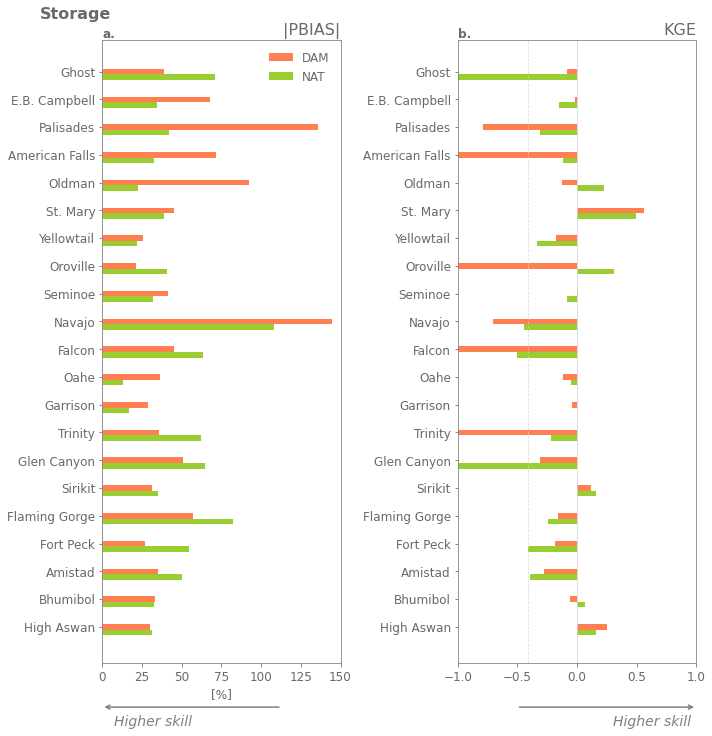

In [15]:
# plot metrics
#metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
metrics_all_dict = {'MARE':mare_dict,'KGE':kge_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$', 'MARE': '|PBIAS|'} # convert mare into pbias by multiplying with 100. 
metrics_limits = {'RMSE': (0,1500),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2), 'MARE':(0,225)}
metric_xlabels = {'KGE':'','MARE':'[%]'}

#cases = cases_bc # only work with biascorrected cases from now on
# initialise figure

for variable in ['outflow', 'storage']: 
    fig, axes = plt.subplots(1,2, figsize=(10,10))

    if variable == 'outflow': 
        cases_toplot = cases
        metrics_limits = {'RMSE': (0,1500),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2), 'MARE':(0,225)}

    if variable == 'storage': 
        cases_toplot = cases[:-1]
        metrics_limits = {'RMSE': (0,1500),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2), 'MARE':(0,150)}


    # sort data
    for n,metric in enumerate(metrics_all_dict.keys()): 
        metric_dict = metrics_all_dict[metric]
        reservoir_subset_unsorted = list(metrics_all_dict[metric].keys())
        reservoir_subset = names_sorted.loc[names_sorted['name'].isin(reservoir_subset_unsorted)]['name'].values.tolist() # sort the names

        scores = np.empty((len(cases_toplot),len(reservoir_subset)))
        
        reservoir_subset.reverse()
        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in cases_toplot: 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores) 

        if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
            scores = scores-1
            
        if metric == 'MARE': 
            scores = scores*100
        
        x_labels = metric_dict.keys

        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

        ax = axes[n]

        for i,score in enumerate(scores):  
            ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_dict[cases_toplot[i]], color=colors_dict[cases_toplot[i]])

        reservoir_subset_names = [names_dict[k] for k in reservoir_subset] 
        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset_names)
        ax.set_title(metrics_titles[metric],loc='right')
        ax.set_xlim(metrics_limits[metric])
        ax.text(0, 1.005, panel_labels[n], color='dimgrey', fontsize=12, transform=ax.transAxes, fontweight='semibold');
        ax.set_xlabel(metric_xlabels[metric])
        if metric == 'KGE': 
            ax.annotate('', xy=(0.25,-0.07), xycoords=("axes fraction"), xytext=(1,-0.07), arrowprops=dict(arrowstyle="<-", color="gray",linewidth=1.5));
            ax.annotate('Higher skill', xy=(0.65,-0.1), xycoords=("axes fraction"), xytext=(0.65,-0.1), fontsize=14, color="gray",style='italic'); 
        else:
            ax.annotate('', xy=(0,-0.07), xycoords=("axes fraction"), xytext=(0.75,-0.07), arrowprops=dict(arrowstyle="->", color="gray",linewidth=1.5));
            ax.annotate('Higher skill', xy=(0.05,-0.1), xycoords=("axes fraction"), xytext=(0.05,-0.1), fontsize=14, color="gray",style='italic');        


       # ax.set_xlabel('[-]')
        if metric == 'KGE': 
            ax.axvline(-0.41, linewidth=0.8, color='lightgray', alpha=0.8, linestyle='--')
       # elif metric == 'MARE': 
        #    ax.axvline(1, linewidth=0.8, color='lightgray', alpha=0.8, linestyle='--')

        ax.axvline(0, linewidth=0.8, color='lightgray')
        if n ==1 : ax.invert_xaxis()
        if n==0: 
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], labels[::-1]);
    fig.tight_layout()
    fig.text(0.06, 0.99, variable.capitalize(), fontsize=16, fontweight='semibold'); 
    fig.savefig(scriptsdir+'plots/kge_pbias_'+variable+'.png', bbox_inches="tight", dpi=600)



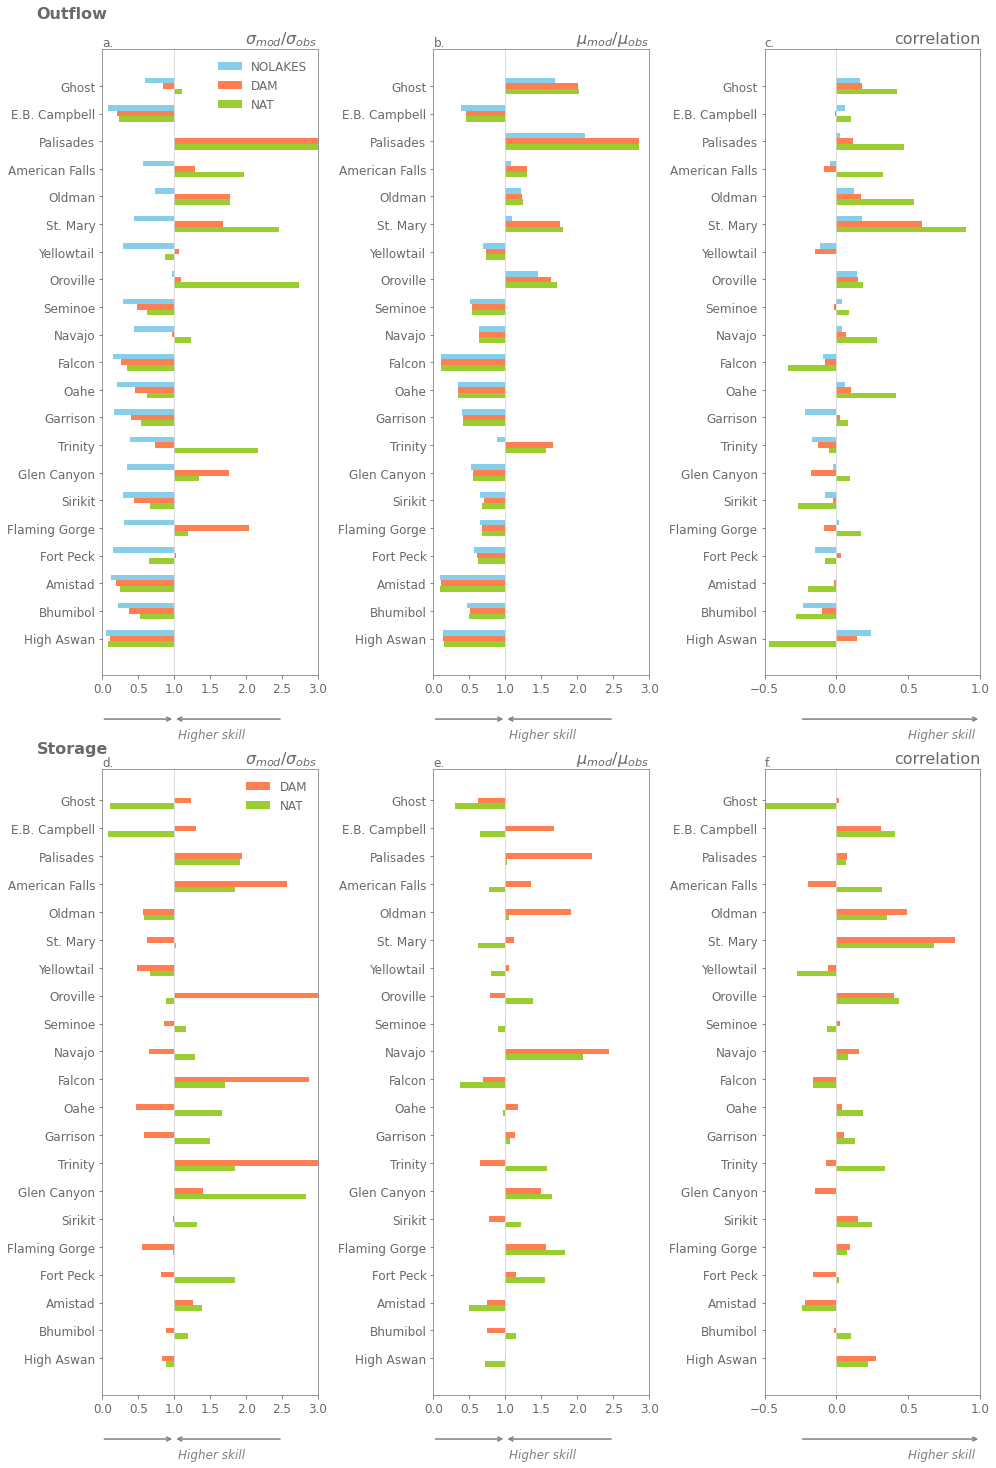

In [16]:
# plot metrics
variable = 'outflow'
#metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
metrics_all_dict = {'alpha': alpha_dict, 'beta':beta_dict, 'pearson': pearson_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}



#cases = cases_bc # only work with biascorrected cases from now on
# initialise figure
fig, axes = plt.subplots(2,3, figsize=(14,20))

count = 0
for l, variable in enumerate(['outflow','storage']): 
    
    if variable == 'storage': 
        metrics_limits = {'RMSE': (0,1.4e10),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,2), 'beta': (-1,2)}
        cases_toplot = cases[:-1]

    else: 
        metrics_limits = {'RMSE': (0,1500),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,2), 'beta': (-1,2)}
        cases_toplot = cases

    # sort data
    for n,metric in enumerate(metrics_all_dict.keys()): 
        metric_dict = metrics_all_dict[metric]
        reservoir_subset_unsorted = list(metrics_all_dict[metric].keys())
        reservoir_subset = names_sorted.loc[names_sorted['name'].isin(reservoir_subset_unsorted)]['name'].values.tolist() # sort the names
        reservoir_subset.reverse()

        scores = np.empty((len(cases_toplot),len(reservoir_subset)))

        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in cases_toplot: 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores)

        # # 1 is best value, let them center around 0 and adjust tick labels. 
        #    scores = scores-1

        x_labels = metric_dict.keys

        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  


        ax = axes[l][n]
        ax.set_xlim(metrics_limits[metric])

        for i,score in enumerate(scores): 
            if metric == 'alpha' or metric == 'beta':
                score = score-1
            ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_dict[cases_toplot[i]], color=colors_dict[cases_toplot[i]])

        if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels.  
            xticks = ax.get_xticks()
            xticks_tolabel = xticks+1
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks_tolabel)

        if metric == 'pearson':
            ax.axvline(1, linewidth=0.8, color='lightgray')
        
        reservoir_subset_names = [names_dict[k] for k in reservoir_subset] 
        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset_names)
        ax.set_title(metrics_titles[metric],loc='right')
        if metric == 'RMSE': 
            ax.set_xlabel('[m³/s]')
        ax.axvline(0, linewidth=0.8, color='lightgray')
        if n==0: 
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], labels[::-1]);
        ax.text(0, 1.005, panel_labels[count], color='dimgrey', fontsize=12, transform=ax.transAxes);

        
        if metric == 'alpha' or metric == 'beta':
            ax.annotate('', xy=(-1,-0.07), xycoords=("data","axes fraction"), xytext=(0,-0.07), arrowprops=dict(arrowstyle="<-", color="gray",linewidth=1.5));
            ax.annotate('', xy=(0,-0.07), xycoords=("data","axes fraction"), xytext=(1.5,-0.07), arrowprops=dict(arrowstyle="->", color="gray",linewidth=1.5));

            ax.annotate('Higher skill', xy=(0.05,-0.1), xycoords=("data", "axes fraction"), xytext=(0.05,-0.1), fontsize=12, color="gray",style='italic');        

        else: 
            
            ax.annotate('', xy=(-0.25,-0.07), xycoords=("data","axes fraction"), xytext=(1,-0.07), arrowprops=dict(arrowstyle="<-", color="gray",linewidth=1.5));

            ax.annotate('Higher skill', xy=(0,-0.1), xycoords=("data", "axes fraction"), xytext=(0.5,-0.1), fontsize=12, color="gray",style='italic');        

        
        count = count+1

fig.text(0.04, 1, 'Outflow', fontsize=16, fontweight='semibold'); 

fig.text(0.04, 0.49,'Storage', fontsize=16, fontweight='semibold'); 

fig.tight_layout()
fig.subplots_adjust( hspace=0.15)
fig.savefig(scriptsdir+'plots/kge_terms.png', bbox_inches="tight", dpi=600)


## Values for paper

In [39]:
metrics_all_dict = {'MARE':mare_dict,'KGE':kge_dict}

for variable in ['outflow', 'storage']: 
    print(variable)
    
    for metric in ['MARE', 'KGE']:
        print(metric)
        metric_dict = metrics_all_dict[metric]
        for case in cases: 
            res_scores = []
            for reservoir in list(metrics_all_dict[metric].keys()): 
                
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            print(case+' median '+ str(np.round(np.median(res_scores),2) ))
        print('')
    print('')          

outflow
MARE
natlake median 0.75
H06 median 0.68
nolake median 0.93

KGE
natlake median -0.23
H06 median -0.29
nolake median -0.35


storage
MARE
natlake median 0.39
H06 median 0.39
nolake median 315.03

KGE
natlake median -0.15
H06 median -0.16
nolake median -331.4




## NOT USED

In [5]:
#with open('natlake_bc_delta_H06_bc_delta.pickle', 'wb') as handle:
 #   pickle.dump(df_mod_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('nolake_H06_noirrig.pickle', 'wb') as handle:
    pickle.dump(df_mod_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


#with open('natlake_H06.pickle', 'wb') as handle:
 #   pickle.dump(df_mod_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('filename.pickle', 'rb') as handle:
 #   b = pickle.load(handle)

#with open('H06_noirrig_bc_delta_nolake_bc_delta.pickle', 'wb') as handle:
#    pickle.dump(df_mod_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('natlake_natlake_bc_natlake_bc_delta.pickle', 'wb') as handle:
#    pickle.dump(df_mod_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [17]:
# load pickles
with open('nolake_H06_noirrig_bc.pickle', 'rb') as handle:
    d1 = pickle.load(handle)

with open('natlake_H06.pickle', 'rb') as handle:
    d2 = pickle.load(handle)
    
with open('natlake.pickle', 'rb') as handle:
    d3 = pickle.load(handle)

#with open('natlake_bc_delta_H06_bc_delta.pickle', 'rb') as handle:
#    d4 = pickle.load(handle)
    
#with open('H06_noirrig_bc_delta_nolake_bc_delta.pickle', 'rb') as handle:
#    d5 = pickle.load(handle)
    

In [18]:
df_mod_dict = {}

for key in d3.keys(): 
    #values_d1 = d1[key]
    #values_d2 = d2[key]
    values_d3 = d3[key]
    #values_d4 = d4[key]
    #values_d5 = d5[key]    
    #df_mod_dict[key] = {values_d1, values_d2, values_d3}
    
    reservoir_dict = {**values_d3}#, **values_d2, **values_d3} #,, **values_d4, **values_d5
    
    df_mod_dict[key] = reservoir_dict

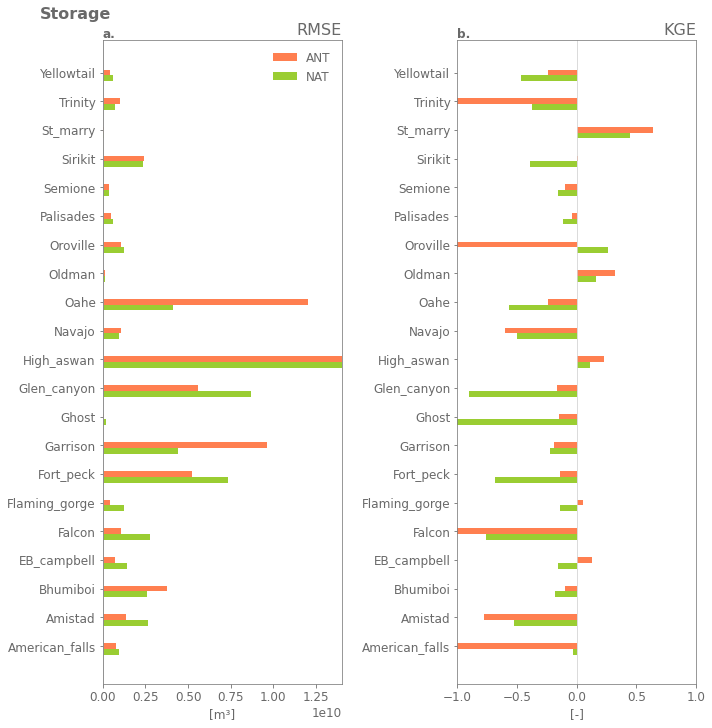

In [47]:
# plot metrics
variable = 'storage'
#metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
metrics_all_dict = {'RMSE':rmse_dict,'KGE':kge_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}
metrics_limits = {'RMSE': (0,1.4e10),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2)}
panel_labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.']


# plot timeseries per variable for all non-irrigation reservoirs
irrig_res_names = df_meta.loc[df_meta['purpose']=='irrigation','name']

names_irrig = set(list(list(metrics_all_dict[list(metrics_all_dict.keys())[0]].keys()))).intersection(irrig_res_names)
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3
names_nonirrig = intersection(list(metrics_all_dict[list(metrics_all_dict.keys())[0]].keys()),names_irrig)

#cases = cases_bc # only work with biascorrected cases from now on
# initialise figure

fig, axes = plt.subplots(1,2, figsize=(10,10)) 
cases_toplot = cases[2:-1]

# sort data
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    reservoir_subset = list(metrics_all_dict[metric].keys())

    scores = np.empty((len(cases_toplot),len(reservoir_subset)))

    for i,reservoir in enumerate(reservoir_subset):
        res_scores = []
        for case in cases_toplot: 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
        scores = scores-1

    x_labels = metric_dict.keys

    barWidth = 0.2  

    # Set position of bar on X axis
    barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

    ax = axes[n]

    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_dict[cases_toplot[i]], color=colors_dict[cases_toplot[i]])


    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(reservoir_subset)
    ax.set_title(metrics_titles[metric],loc='right')
    ax.set_xlim(metrics_limits[metric])
    ax.text(0, 1.005, panel_labels[n], color='dimgrey', fontsize=12, transform=ax.transAxes, fontweight='semibold');

    if metric == 'RMSE': 
        ax.set_xlabel('[m³]')
    else: 
        ax.set_xlabel('[-]')
    ax.axvline(0, linewidth=0.8, color='lightgray')
    if n ==1 : ax.invert_xaxis()
    if n==0: 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1]);
fig.tight_layout()
fig.text(0.06, 0.99, 'Storage', fontsize=16, fontweight='semibold'); 
fig.savefig(scriptsdir+'plots/KGE_RMSE_storage.png', bbox_inches="tight")


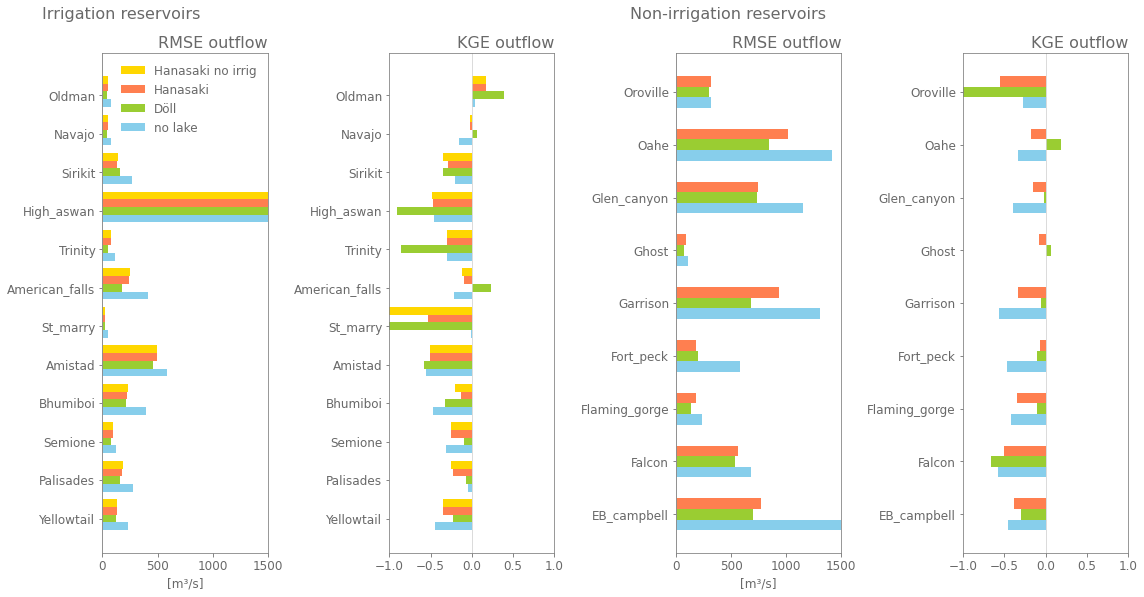

In [13]:
# plot metrics
variable = 'outflow'
#metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
metrics_all_dict = {'RMSE':rmse_dict,'KGE':kge_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}
metrics_limits = {'RMSE': (0,1500),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2)}


# plot timeseries per variable for all non-irrigation reservoirs
irrig_res_names = df_meta.loc[df_meta['purpose']=='irrigation','name']

names_irrig = set(list(list(metrics_all_dict[list(metrics_all_dict.keys())[0]].keys()))).intersection(irrig_res_names)
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3
names_nonirrig = intersection(list(metrics_all_dict[list(metrics_all_dict.keys())[0]].keys()),names_irrig)




#cases = cases_bc # only work with biascorrected cases from now on
# initialise figure
fig, axes = plt.subplots(1,4, figsize=(16,8))

for k, reservoir_subset in enumerate([list(names_irrig),names_nonirrig]):

        if k == 0: # irrigation reservoirs 
            cases_toplot  = cases[1:]
        
        else: # non - irrigation reservoirs
            cases_toplot = cases[1:-1]
    
    
    # sort data
        for n,metric in enumerate(metrics_all_dict.keys()): 
            metric_dict = metrics_all_dict[metric]

            scores = np.empty((len(cases_toplot),len(reservoir_subset)))

            for i,reservoir in enumerate(reservoir_subset):
                res_scores = []
                for case in cases_toplot: 
                    res_scores.append(metric_dict[reservoir][case][variable].squeeze())
                scores[:,i] = np.array(res_scores)

            if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
                scores = scores-1

            x_labels = metric_dict.keys

            barWidth = 0.2  

            # Set position of bar on X axis
            barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
            barpositions[0,:] = np.arange(len(scores[0,:]))

            for i in range(1,barpositions.shape[0]):
                barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

            if k == 0: 
                ax = axes[n]
            else: 
                ax = axes[2+n]

            for i,score in enumerate(scores):  
                ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_dict[cases_toplot[i]], color=colors_dict[cases_toplot[i]])


            ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
            ax.set_yticklabels(reservoir_subset)
            ax.set_title(metrics_titles[metric]+' '+variable,loc='right')
            ax.set_xlim(metrics_limits[metric])
            if metric == 'RMSE': 
                ax.set_xlabel('[m³/s]')
            ax.axvline(0, linewidth=0.8, color='lightgray')
            if n ==1 : ax.invert_xaxis()
            if n==0 and k==0: 
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles[::-1], labels[::-1]);
fig.text(0.04, 1.01, 'Irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.text(0.55, 1.01, 'Non-irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.tight_layout()
fig.savefig(scriptsdir+'plots/KGE_RMSE_outflow.png', bbox_inches="tight")


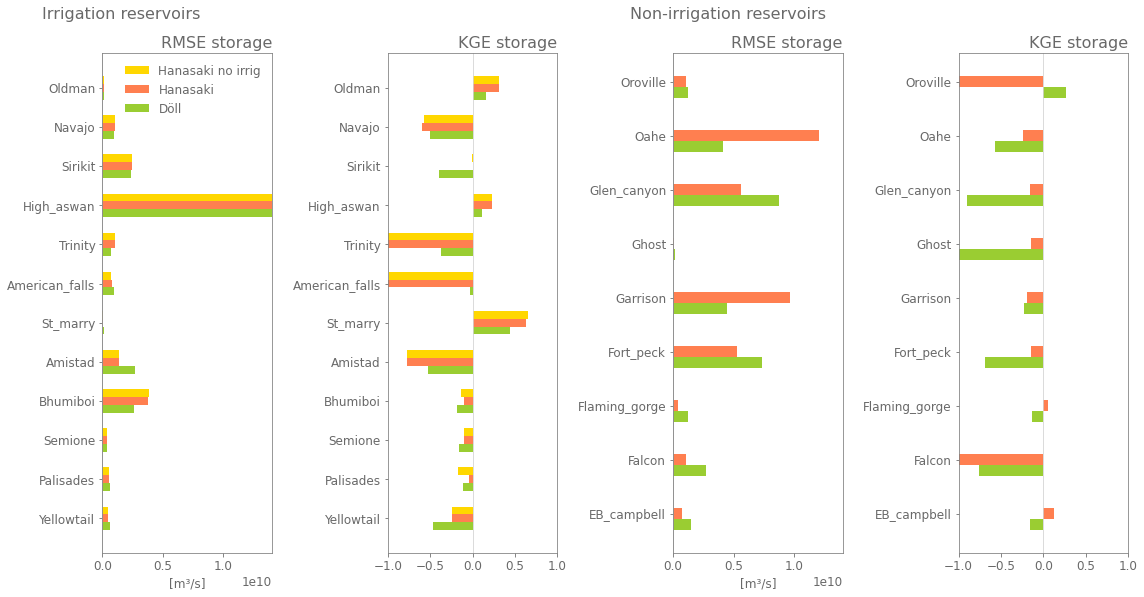

In [14]:
# plot metrics
variable = 'storage'
#metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
metrics_all_dict = {'RMSE':rmse_dict,'KGE':kge_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}
metrics_limits = {'RMSE': (0,1.4e10),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2)}


# plot timeseries per variable for all non-irrigation reservoirs
irrig_res_names = df_meta.loc[df_meta['purpose']=='irrigation','name']

names_irrig = set(list(list(metrics_all_dict[list(metrics_all_dict.keys())[0]].keys()))).intersection(irrig_res_names)
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3
names_nonirrig = intersection(list(metrics_all_dict[list(metrics_all_dict.keys())[0]].keys()),names_irrig)




#cases = cases_bc # only work with biascorrected cases from now on
# initialise figure
fig, axes = plt.subplots(1,4, figsize=(16,8))

for k, reservoir_subset in enumerate([list(names_irrig),names_nonirrig]):

        if k == 0: # irrigation reservoirs 
            cases_toplot  = cases[2:]
        
        else: # non - irrigation reservoirs
            cases_toplot = cases[2:-1]
    
    
    # sort data
        for n,metric in enumerate(metrics_all_dict.keys()): 
            metric_dict = metrics_all_dict[metric]

            scores = np.empty((len(cases_toplot),len(reservoir_subset)))

            for i,reservoir in enumerate(reservoir_subset):
                res_scores = []
                for case in cases_toplot: 
                    res_scores.append(metric_dict[reservoir][case][variable].squeeze())
                scores[:,i] = np.array(res_scores)

            if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
                scores = scores-1

            x_labels = metric_dict.keys

            barWidth = 0.2  

            # Set position of bar on X axis
            barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
            barpositions[0,:] = np.arange(len(scores[0,:]))

            for i in range(1,barpositions.shape[0]):
                barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

            if k == 0: 
                ax = axes[n]
            else: 
                ax = axes[2+n]

            for i,score in enumerate(scores):  
                ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_dict[cases_toplot[i]], color=colors_dict[cases_toplot[i]])


            ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
            ax.set_yticklabels(reservoir_subset)
            ax.set_title(metrics_titles[metric]+' '+variable,loc='right')
            ax.set_xlim(metrics_limits[metric])
            if metric == 'RMSE': 
                ax.set_xlabel('[m³]')
            ax.axvline(0, linewidth=0.8, color='lightgray')
            if n ==1 : ax.invert_xaxis()
            if n==0 and k==0: 
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles[::-1], labels[::-1]);
fig.text(0.04, 1.01, 'Irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.text(0.55, 1.01, 'Non-irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.tight_layout()
fig.savefig(scriptsdir+'plots/KGE_RMSE_storage.png', bbox_inches="tight")


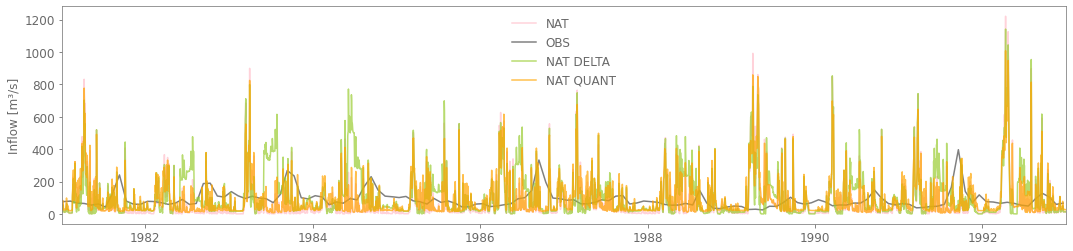

In [17]:
reservoir_name = 'Semione'
    ########
    # do plotting
fig, axes = plt.subplots(1,1, figsize = (18,4))
df_res_dict = df_mod_dict[reservoir_name]
for n,variable in enumerate( ['inflow']):
    for j, case in enumerate(cases):                      
    # plot timeseries
        axes.plot(df_res_dict[case].index,df_res_dict[case][variable], label=cases_longname_dict[case], color=colors_dict[case], alpha=0.7)

        # plot obs only once (not for every case)
        if j == 0: axes.plot(df_obs.index, df_obs[variable], color="gray", label = "OBS")

        if variable == 'storage': 
            ylabel = 'Storage [m³]'
        elif variable == 'inflow' :
            ylabel  =  'Inflow [m³/s]'
        else: ylabel='Outflow [m³/s]'

        axes.set_ylabel(ylabel); 
        axes.set_xlim([df_res_dict[case].index.min(),df_res_dict[case].index.max()]); 
        axes.legend()



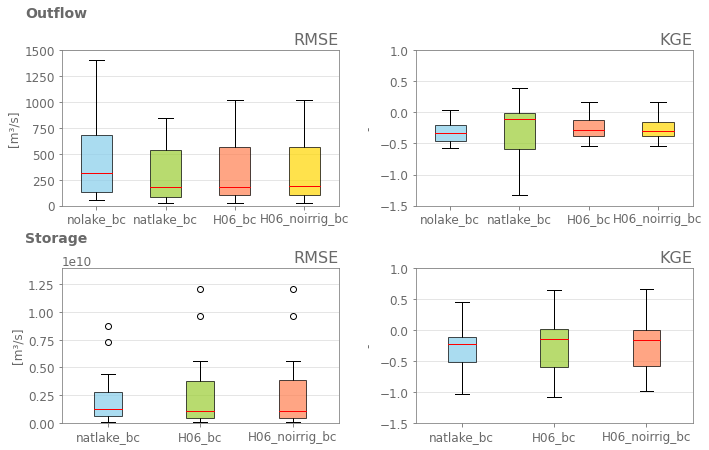

In [25]:
variable = 'outflow'
metrics = ['RMSE','KGE']

metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict, 'alpha': alpha_dict, 'beta':beta_dict, 'pearson': pearson_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}



units = {'KGE': '-', 'RMSE': '[m³/s]', 'alpha': '-', 'beta': '-'}
fig, axes = plt.subplots(2,len(metrics), figsize=(10,6))

for k, variable in enumerate(['outflow','storage']): 
    
    
    if k == 0: # outflow
        cases_toplot  = cases[1:]
        metrics_limits = {'RMSE': (0,1500),'KGE': (-1.5,1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2)}

    else: # storage
        cases_toplot = cases[2:]
        metrics_limits = {'RMSE': (0,1.4e10),'KGE': (-1.5,1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2)}

    
    
    # sort data
    dict_score_percase = {}
    for n,metric in enumerate(metrics_all_dict.keys()): 
        metric_dict = metrics_all_dict[metric]


        metric_score_percase = np.empty((len(metric_dict.keys()), len(cases_toplot)))

        for i, case in enumerate(cases_toplot): 
            case_scores = []
            for reservoir in metric_dict.keys():
                case_scores.append(metric_dict[reservoir][case][variable].squeeze())
            metric_score_percase[:,i] = case_scores
        dict_score_percase[metric] = np.array(metric_score_percase)


    
    for i, metric in enumerate(metrics):
        ax = axes[k][i]
        bplot = ax.boxplot(dict_score_percase[metric],patch_artist=True, medianprops=dict(color='r'));
        ax.yaxis.grid(True, linestyle='-', which='major', color='silver', alpha=0.5)
        ax.set_xticklabels(cases_toplot)
        ax.set_title(metrics_titles[metric], loc='right')
        ax.set_ylabel(units[metric]);
        ax.set_ylim(metrics_limits[metric])

        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
fig.text(0.04, 1.01, 'Outflow', fontsize=14, fontweight='semibold'); 
fig.text(0.04, 0.49, 'Storage', fontsize=14, fontweight='semibold'); 
fig.tight_layout()
fig.subplots_adjust( hspace=0.4)
fig.savefig(scriptsdir+'plots/KGE_RMSE_boxplots.png', bbox_inches="tight")


In [26]:
## get cateogry of every reservoir
# list irrigation and non irrigation reservoirs

names_irrig = []
names_noirrig = []
for reservoir in rmse_dict.keys():
    if res_info[reservoir]['purpose'] == 'irrigation': names_irrig.append(reservoir)
    else: names_noirrig.append(reservoir)

# list small and big reservoirs   
names_small = []
names_big = []
for reservoir in rmse_dict.keys():
    if res_info[reservoir]['size'] == 'within-a-year': names_small.append(reservoir)
    else: names_big.append(reservoir)


In [ ]:
# plot metrics
variable = 'storage'
#metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
metrics_all_dict = {'alpha': alpha_dict, 'beta':beta_dict, 'pearson': pearson_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}
metrics_limits = {'RMSE': (0,1.4e10),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2)}


# plot timeseries per variable for all non-irrigation reservoirs
irrig_res_names = df_meta.loc[df_meta['purpose']=='irrigation','name']

names_irrig = set(list(list(metrics_all_dict[list(metrics_all_dict.keys())[0]].keys()))).intersection(irrig_res_names)
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3
names_nonirrig = intersection(list(metrics_all_dict[list(metrics_all_dict.keys())[0]].keys()),names_irrig)




#cases = cases_bc # only work with biascorrected cases from now on
# initialise figure
fig, axes = plt.subplots(2,3, figsize=(14,16))

for k, reservoir_subset in enumerate([list(names_irrig),names_nonirrig]):

        if k == 0: # irrigation reservoirs 
            cases_toplot  = cases[1:]
        
        else: # non - irrigation reservoirs
            cases_toplot = cases[1:-1]
    
    
    # sort data
        for n,metric in enumerate(metrics_all_dict.keys()): 
            metric_dict = metrics_all_dict[metric]

            scores = np.empty((len(cases_toplot),len(reservoir_subset)))

            for i,reservoir in enumerate(reservoir_subset):
                res_scores = []
                for case in cases_toplot: 
                    res_scores.append(metric_dict[reservoir][case][variable].squeeze())
                scores[:,i] = np.array(res_scores)

            if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
                scores = scores-1

            x_labels = metric_dict.keys

            barWidth = 0.2  

            # Set position of bar on X axis
            barpositions = np.empty((len(cases_toplot),len(reservoir_subset)))
            barpositions[0,:] = np.arange(len(scores[0,:]))

            for i in range(1,barpositions.shape[0]):
                barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

            ax = axes[k][n]

            for i,score in enumerate(scores):  
                ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_dict[cases_toplot[i]], color=colors_dict[cases_toplot[i]])

            if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels.  
                xticks = ax.get_xticks()
                ax.set_xticklabels((xticks+1))
            if metric == 'pearson':
                ax.axvline(1, linewidth=0.8, color='lightgray')
                
            ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
            ax.set_yticklabels(reservoir_subset)
            ax.set_title(metrics_titles[metric]+' '+variable,loc='right')
            ax.set_xlim(metrics_limits[metric])
            if metric == 'RMSE': 
                ax.set_xlabel('[m³/s]')
            ax.axvline(0, linewidth=0.8, color='lightgray')
            if n ==1 : ax.invert_xaxis()
            if n==0 and k==0: 
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles[::-1], labels[::-1]);
fig.text(0.04, 1.01, 'Irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.text(0.04, 0.49, 'Non-irrigation reservoirs', fontsize=16, fontstyle='normal'); 
fig.tight_layout()
fig.subplots_adjust( hspace=0.15)


In [ ]:
# plot metrics
variable = 'outflow'
#metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
metrics_all_dict = {'RMSE':rmse_dict,'KGE':kge_dict,  'alpha': alpha_dict, 'beta':beta_dict, 'pearson': pearson_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}
metrics_limits = {'RMSE': (0,1500),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2)}


cases = cases_bc # only work with biascorrected cases from now on
# initialise figure
fig, axes = plt.subplots(1,len(metrics_all_dict.keys()), figsize=(20,8))

# sort data
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    scores = np.empty((len(cases),len(metric_dict.keys())))
    
    for i,reservoir in enumerate(metric_dict.keys()):
        res_scores = []
        for case in metric_dict[reservoir].keys(): 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
        scores = scores-1

    x_labels = metric_dict.keys

    barWidth = 0.2  

    # Set position of bar on X axis
    barpositions = np.empty((len(cases),len(metric_dict.keys())))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

    ax = axes[n]
    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_dict[cases[i]], color=colors_dict[cases[i]])

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels.  
        xticks = ax.get_xticks()
        ax.set_xticklabels((xticks+1))
    if metric == 'pearson':
        ax.axvline(1, linewidth=0.8, color='lightgray')

        
    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(names)
    ax.set_title(metrics_titles[metric],loc='right')
    ax.set_xlim(metrics_limits[metric])
    ax.axvline(0, linewidth=0.8, color='lightgray')
    if n ==1 : ax.invert_xaxis()
    if n==0: 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1]);
fig.tight_layout()
fig.suptitle(variable, fontsize=16,x=0.1, y= 1.02); 


In [ ]:
# plot metrics
variable = 'storage'
#metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
metrics_all_dict = {'RMSE':rmse_dict,'KGE':kge_dict,  'alpha': alpha_dict, 'beta':beta_dict, 'pearson': pearson_dict}
metrics_titles = {'RMSE':'RMSE','KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}
metrics_limits = {'RMSE': (0,1.4e10),'KGE': (1,-1), 'pearson': (-0.5,1), 'alpha':(-1,1.4), 'beta': (-1.2,1.2)}

cases = cases_bc[:-1] # only work with biascorrected cases from now on
cases_longname = cases_longname_bc[:-1]
# initialise figure
fig, axes = plt.subplots(1,len(metrics_all_dict.keys()), figsize=(20,8))

# sort data
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    scores = np.empty((len(cases),len(metric_dict.keys())))
    
    for i,reservoir in enumerate(metric_dict.keys()):
        res_scores = []
        for case in cases: 
            res_scores.append(metric_dict[reservoir][case][variable].squeeze())
        scores[:,i] = np.array(res_scores)

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels. 
        scores = scores-1

    x_labels = metric_dict.keys

    barWidth = 0.2  

    # Set position of bar on X axis
    barpositions = np.empty((len(cases),len(metric_dict.keys())))
    barpositions[0,:] = np.arange(len(scores[0,:]))

    for i in range(1,barpositions.shape[0]):
        barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

    ax = axes[n]
    for i,score in enumerate(scores):  
        ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors_dict[cases[i]])

    if metric == 'alpha' or metric == 'beta': # 1 is best value, let them center around 0 and adjust tick labels.  
        xticks = ax.get_xticks()
        ax.set_xticklabels((xticks+1))
    if metric == 'pearson':
        ax.axvline(1, linewidth=0.8, color='lightgray')

        
    ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
    ax.set_yticklabels(names)
    ax.set_title(metrics_titles[metric],loc='right')
    ax.set_xlim(metrics_limits[metric])
    ax.axvline(0, linewidth=0.8, color='lightgray')
    if n ==1 : ax.invert_xaxis()
    if n==0: 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1]);
fig.tight_layout()
fig.suptitle(variable, fontsize=16,x=0.1, y= 1.02); 


In [ ]:
# plot metric per reservoir type: IRRIGATION
variable='outflow'
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}
units = {'KGE': '-', 'pearson': '-', 'alpha': '-', 'beta': '-'}
limits = {'KGE': (1,-2.5), 'pearson': (-0.5,0.5), 'alpha':(-0.1,4), 'beta': (0,3)}
titles = {'KGE':'KGE', 'pearson': 'correlation', 'alpha': '$\sigma_{mod}$/$\sigma_{obs}$', 'beta': '$\mu_{mod}$/$\mu_{obs}$'}


for metric in metrics_all_dict.keys(): 
    # initialise figure
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    n=0
    # sort data

    metric_dict = metrics_all_dict[metric]


    # first plot: irrigation reservoirs 
    reservoir_subset_list = [ names_noirrig, names_irrig]
    title_subset_list = [ 'Non-irrigation reservoirs', 'Irrigation reservoirs']
    for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 

        # define which cases to plot for which category
        if title_subset == 'Non-irrigation reservoirs': 
            cases_toplot = ['nolake', 'H06_noirrig', 'natlake']
            cases_longname_toplot = ['no lakes', 'Hanasaki non irrig', 'Döll' ]
            colors_toplot = [ 'skyblue', 'coral','yellowgreen' ]
        else: 
            cases_toplot = metric_dict[reservoir].keys()
            cases_longname_toplot = cases_longname
            colors_toplot = colors
            
        scores= np.empty((len(cases_toplot),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in cases_toplot: 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores)


        x_labels = reservoir_subset

        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

        ax = axes[n]
        for i,score in enumerate(scores):  
            ax.barworwork
            h(barpositions[i,:], score,height = barWidth, label=cases_longname_toplot[i], color=colors_toplot[i])

        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset)
        ax.set_title(title_subset,loc='right', fontsize=12)
        ax.axvline(0, linewidth=0.8, color='lightgray')
        if metric != 'RMSE' and metric!='MARE' : ax.invert_xaxis()
        if metric == 'RMSE': ax.set_xlabel('m³/s')
        elif metric == 'PBIAS': ax.set_xlabel('%')
        else: ax.set_xlabel('-')
        if n==1: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        n = n+1
    fig.tight_layout()
    fig.suptitle(metric+' for '+variable, fontsize=16,x=0.1, y= 1.02); 




In [ ]:
# plot metric per reservoir type: RESERVOIR SIZE

# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}

for metric in metrics_all_dict.keys(): 
    # initialise figure
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    n=0
    # sort data

    metric_dict = metrics_all_dict[metric]


    # first plot: irrigation reservoirs 
    reservoir_subset_list = [ names_big, names_small]
    title_subset_list = ['multi-year', 'whithin-a-year']
    for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 

        scores= np.empty((len(cases),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in metric_dict[reservoir].keys(): 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores)


        x_labels = reservoir_subset

        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

        ax = axes[n]
        for i,score in enumerate(scores):  
            ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname[i], color=colors[i])

        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset)
        ax.set_title(title_subset,loc='right', fontsize=12)
        ax.axvline(0, linewidth=0.8, color='lightgray')
        if metric == 'NSE' or metric =='KGE' : ax.invert_xaxis()
        if metric == 'RMSE': ax.set_xlabel('m³/s')
        elif metric == 'PBIAS': ax.set_xlabel('%')
        else: ax.set_xlabel('-')
        if n==1: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        n = n+1
    fig.tight_layout()
    fig.suptitle(metric, fontsize=16,x=0.1, y= 1.02); 




IndexError: index 3 is out of bounds for axis 0 with size 3

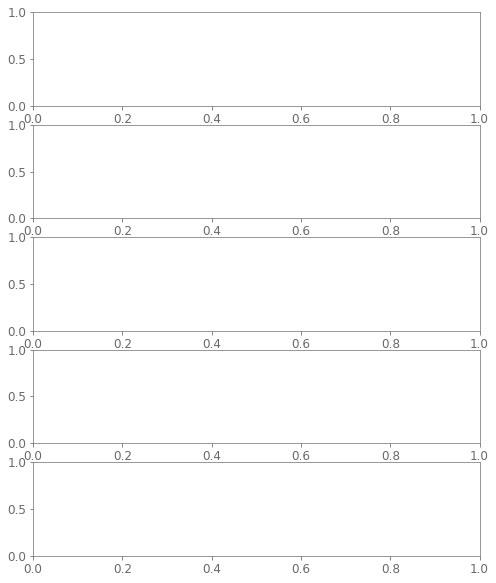

In [24]:
# HEAT PLOTS - all

# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}

# first plot: irrigation reservoirs 
reservoir_subset_list = [ names_big, names_small]
title_subset_list = ['multi-year', 'whithin-a-year']


reservoir_subset = metric_dict.keys()

fig, axes = plt.subplots(5,1, figsize=(8,10))


# properties per metric
cmaps = ['YlOrBr_r','YlOrBr_r', 'YlOrBr','PiYG', 'YlOrBr' ]
metric_units = ['-', '-', 'm³/s', '%', '-']
vmin = [-1.5, -10, 0, -100, 0]
vmax = [0, 0, 10000, 100, 2]
for n, metric in enumerate(metrics_all_dict.keys()): 
    # initialise figure
  
    # sort data
    
    metric_dict = metrics_all_dict[metric]

    
    scores= np.empty((len(cases),len(reservoir_subset)))

    # get scores for irrigation reservoirs 
    for i,reservoir in enumerate(reservoir_subset):
        for j, case in enumerate(metric_dict[reservoir].keys()):         
            scores[j,i] = metric_dict[reservoir][case][variable].squeeze()

    sns.heatmap(scores, ax=axes[n], linewidths=.5, cmap=cmaps[n], vmax=vmax[n], vmin=vmin[n], cbar_kws={"aspect": 4, "label": metric_units[n]}); 
    axes[n].set_yticklabels(cases_longname, rotation='horizontal'); 
    axes[n].set_title(metric, loc='right', fontsize=16); 
    if n < len(metrics_all_dict.keys())-1: 
        axes[n].set_xticklabels([]);
    else: 
        axes[n].set_xticklabels(reservoir_subset, rotation='vertical'); 


    fig.tight_layout()
     
    fig.suptitle(variable, fontsize=16,x=0.1, y= 1.02); 


KeyError: 'nolake'

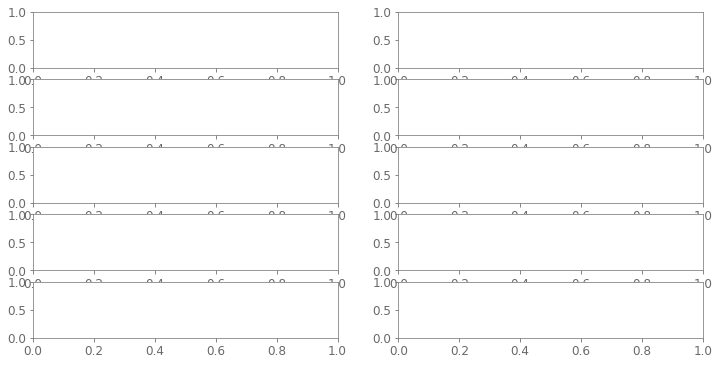

In [25]:
# HEAT PLOTS - per subset

# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict}

# first plot: irrigation reservoirs 
reservoir_subset_list = [ names_noirrig, names_irrig]
title_subset_list = [ 'Non-irrigation reservoirs', 'Irrigation reservoirs']


fig, axes = plt.subplots(5,len(reservoir_subset_list), figsize=(12,6))

# counter
c = 0
for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 
    # define which cases to plot for which category
    if title_subset == 'Non-irrigation reservoirs': 
        cases_toplot = ['nolake', 'H06_noirrig', 'natlake']
        cases_longname_toplot = cases_longname#['no lakes', 'Hanasaki non irrig', 'Döll' ]
    else: 
        cases_toplot = metric_dict[reservoir].keys()
        cases_longname_toplot = cases_longname
    
    
    # properties per metric
    cmaps = ['YlOrBr_r','YlOrBr_r', 'YlOrBr' ]
    metric_units = ['[-]', '[-]', '[m³/s]']
    vmin = [-1.5, -5, 0, 0 , 0]
    vmax = [1, 1, 3, 3, 3]
    for n, metric in enumerate(metrics_all_dict.keys()): 
        # initialise figure

        # sort data

        metric_dict = metrics_all_dict[metric]


        scores= np.empty((len(cases_toplot),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            for j, case in enumerate(cases_toplot):         
                scores[j,i] = metric_dict[reservoir][case][variable].squeeze()
        ax =  axes[n,c]
        # only colorbar in last column and ylabels in first column
        cbar_flag = False if c != len(reservoir_subset_list)-1 else True
        yticklabels = cases_longname #if c == 0 else []

        sns.heatmap(scores, ax=ax, linewidths=.5, cmap=cmaps[n], vmax=vmax[n], vmin=vmin[n], cbar = cbar_flag, cbar_kws={"aspect": 4, "label": metric_units[n]}); 
        ax.set_yticklabels(yticklabels, rotation='horizontal'); 
        ax.set_title(metric, loc='right', fontsize=14); 
        if n < len(metrics_all_dict.keys())-1: 
            ax.set_xticklabels([]);
        else: 
            ax.set_xticklabels(reservoir_subset, rotation='vertical'); 

    c= c+1

fig.tight_layout()
fig.suptitle(variable, fontsize=16,x=0.1, y= 1.02); 



AttributeError: 'dict' object has no attribute 'squeeze'

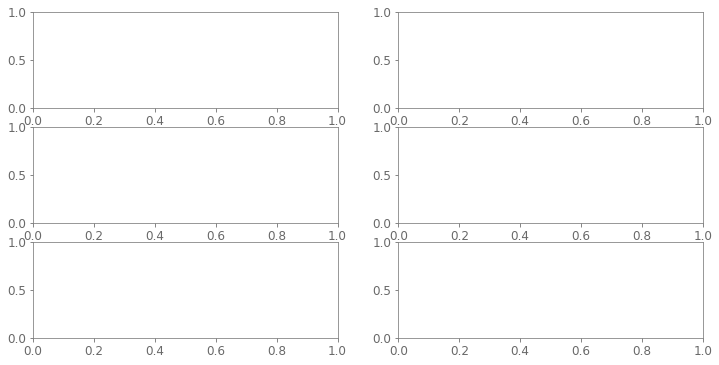

In [26]:
# HEAT PLOTS - per subset

# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict, 'PBIAS': pbias_dict, 'MARE':mare_dict, 'alpha': alpha_dict, 'beta_dict':beta_dict, 'pearson': pearson_dict}

# first plot: irrigation reservoirs 
reservoir_subset_list = [ names_big, names_small]
title_subset_list = ['multi-year', 'whithin-a-year']

fig, axes = plt.subplots(3,len(reservoir_subset_list), figsize=(12,6))

# counter
c = 0
for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 

    # properties per metric
    cmaps = ['YlOrBr_r','YlOrBr_r', 'YlOrBr' ]
    metric_units = ['[-]', '[-]', '[m³/s]']
    vmin = [-1.5, -5, 0]
    vmax = [1, 1, 3]
    for n, metric in enumerate(metrics_all_dict.keys()): 
        # initialise figure

        # sort data

        metric_dict = metrics_all_dict[metric]


        scores= np.empty((len(cases),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            for j, case in enumerate(metric_dict[reservoir].keys()):         
                scores[j,i] = metric_dict[reservoir][case].squeeze()
        ax =  axes[n,c]
        # only colorbar in last column and ylabels in first column
        cbar_flag = False if c != len(reservoir_subset_list)-1 else True
        yticklabels = cases_longname #if c == 0 else []

        sns.heatmap(scores, ax=ax, linewidths=.5, cmap=cmaps[n], vmax=vmax[n], vmin=vmin[n], cbar = cbar_flag, cbar_kws={"aspect": 4, "label": metric_units[n]}); 
        ax.set_yticklabels(yticklabels, rotation='horizontal'); 
        ax.set_title(metric, loc='right', fontsize=14); 
        if n < len(metrics_all_dict.keys())-1: 
            ax.set_xticklabels([]);
        else: 
            ax.set_xticklabels(reservoir_subset, rotation='vertical'); 

    c= c+1

fig.tight_layout()



## boxplots

KeyError: 'KGE'

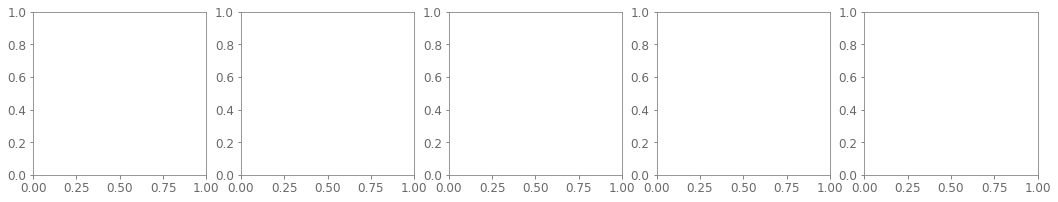

In [97]:
metrics = ['KGE', 'NSE','RMSE', 'MARE','PBIAS']

units = {'KGE': '-', 'NSE': '-', 'RMSE': 'm³/s', 'MARE': '-','PBIAS': '%'}
limits = {'KGE': (1,-2.5), 'NSE': (1,-15), 'RMSE':(-100,2000), 'MARE': (0,2.5),'PBIAS': (-200,100)}

fig, axes = plt.subplots(1,len(metrics), figsize=(18,3))

for i, metric in enumerate(metrics):
    
    bplot = axes[i].boxplot(dict_score_percase[metric],patch_artist=True, medianprops=dict(color='r'));
    axes[i].yaxis.grid(True, linestyle='-', which='major', color='silver', alpha=0.5)
    axes[i].set_xticklabels(cases_simple)
    axes[i].set_title(metric, loc='right')
    axes[i].set_ylabel(units[metric]);
    axes[i].set_ylim(limits[metric])
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

fig.tight_layout()

## Make metrics plots for storage

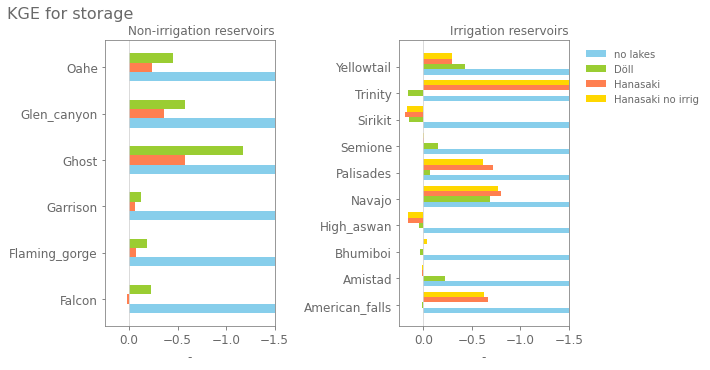

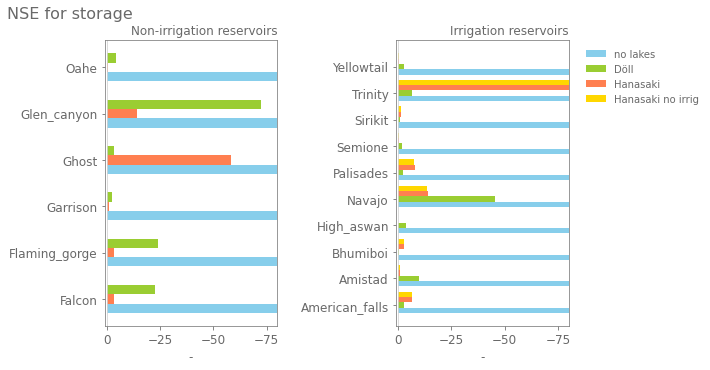

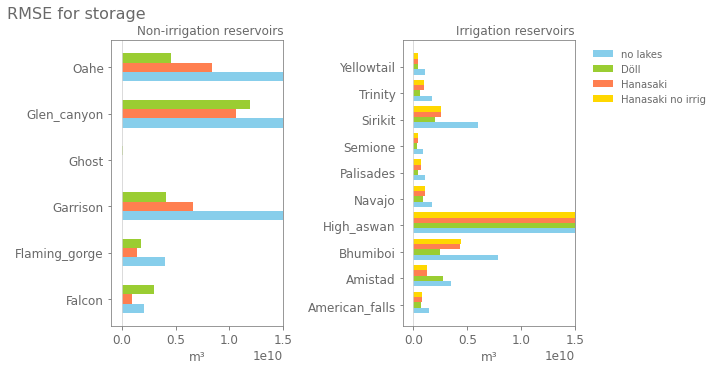

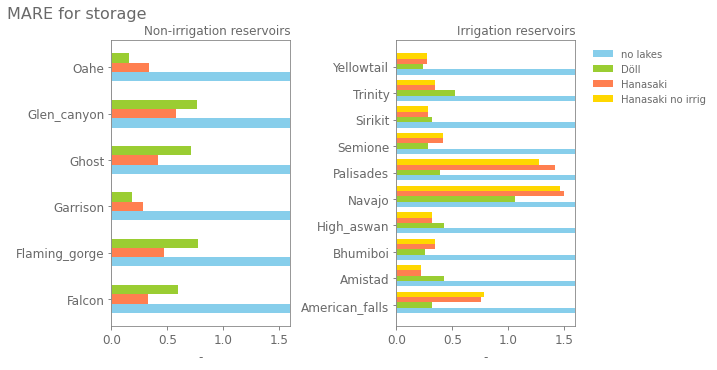

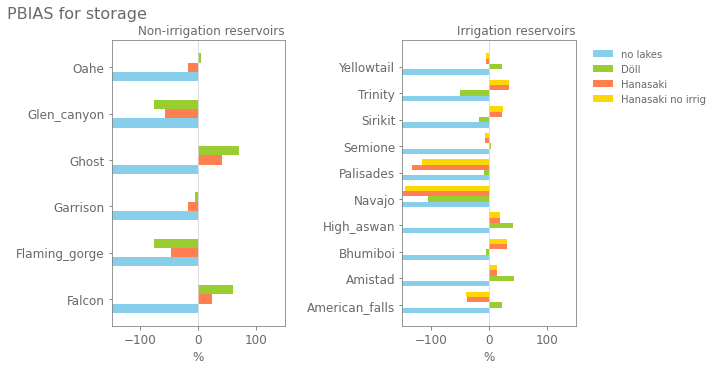

In [15]:
# plot metric per reservoir type: IRRIGATION
variable='storage'
# combine metrics in dict
metrics_all_dict = {'KGE':kge_dict, 'NSE':nse_dict,'RMSE':rmse_dict,  'MARE':mare_dict,'PBIAS': pbias_dict}


limits = {'KGE': (0.25,-1.5), 'NSE': (1,-80), 'RMSE':(-0.1e10,1.5e10), 'MARE': (0,1.6),'PBIAS': (-150,150)}

for metric in metrics_all_dict.keys(): 
    # initialise figure
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    n=0
    # sort data

    metric_dict = metrics_all_dict[metric]


    # first plot: irrigation reservoirs 
    reservoir_subset_list = [ names_noirrig, names_irrig]
    title_subset_list = [ 'Non-irrigation reservoirs', 'Irrigation reservoirs']
    for reservoir_subset, title_subset in zip(reservoir_subset_list, title_subset_list): 

        # define which cases to plot for which category
        if title_subset == 'Non-irrigation reservoirs': 
            cases_toplot = ['nolake', 'H06_noirrig', 'natlake']
            cases_longname_toplot = ['no lakes', 'Hanasaki non irrig', 'Döll' ]
            colors_toplot = [ 'skyblue', 'coral','yellowgreen' ]
        else: 
            cases_toplot = metric_dict[reservoir].keys()
            cases_longname_toplot = cases_longname
            colors_toplot = colors
            
        scores= np.empty((len(cases_toplot),len(reservoir_subset)))

        # get scores for irrigation reservoirs 
        for i,reservoir in enumerate(reservoir_subset):
            res_scores = []
            for case in cases_toplot: 
                res_scores.append(metric_dict[reservoir][case][variable].squeeze())
            scores[:,i] = np.array(res_scores)


        x_labels = reservoir_subset

        barWidth = 0.2  

        # Set position of bar on X axis
        barpositions = np.empty((len(cases),len(reservoir_subset)))
        barpositions[0,:] = np.arange(len(scores[0,:]))

        for i in range(1,barpositions.shape[0]):
            barpositions[i,:] =  [x + barWidth for x in barpositions[i-1,:] ]  

        ax = axes[n]
        for i,score in enumerate(scores):  
            ax.barh(barpositions[i,:], score,height = barWidth, label=cases_longname_toplot[i], color=colors_toplot[i])

        ax.set_yticks([r + barWidth for r in range(len(barpositions[0,:]))])
        ax.set_yticklabels(reservoir_subset)
        ax.set_title(title_subset,loc='right', fontsize=12)
        ax.axvline(0, linewidth=0.8, color='lightgray')
        if metric != 'RMSE' : ax.invert_xaxis()
        if metric == 'RMSE': ax.set_xlabel('m³')
        elif metric == 'PBIAS': ax.set_xlabel('%')
        else: ax.set_xlabel('-')
        ax.set_xlim(limits[metric])

        if n==1: ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        n = n+1
    fig.tight_layout()
    fig.suptitle(metric+' for '+variable, fontsize=16,x=0.1, y= 1.02); 




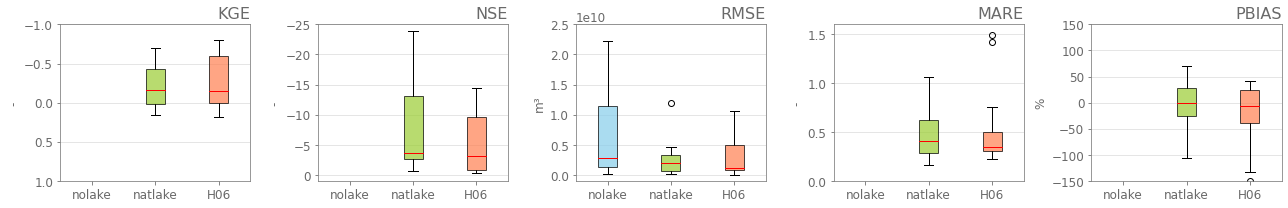

In [16]:
variable='storage'
# sort data
dict_score_percase = {}
for n,metric in enumerate(metrics_all_dict.keys()): 
    metric_dict = metrics_all_dict[metric]
    
    
    metric_score_percase = np.empty((len(metric_dict.keys()), len(cases_simple)))
    
    for i, case in enumerate(cases_simple): 
        case_scores = []
        for reservoir in metric_dict.keys():
            case_scores.append(metric_dict[reservoir][case][variable].squeeze())
        metric_score_percase[:,i] = case_scores
    dict_score_percase[metric] = np.array(metric_score_percase)
    
metrics = ['KGE', 'NSE','RMSE', 'MARE','PBIAS']

units = {'KGE': '-', 'NSE': '-', 'RMSE': 'm³', 'MARE': '-','PBIAS': '%'}
limits = {'KGE': (1,-1), 'NSE': (1,-25), 'RMSE':(-0.1e10,2.5e10), 'MARE': (0,1.6),'PBIAS': (-150,150)}

fig, axes = plt.subplots(1,len(metrics), figsize=(18,3))

for i, metric in enumerate(metrics):
    
    bplot = axes[i].boxplot(dict_score_percase[metric],patch_artist=True, medianprops=dict(color='r'));
    axes[i].yaxis.grid(True, linestyle='-', which='major', color='silver', alpha=0.5)
    axes[i].set_xticklabels(cases_simple)
    axes[i].set_title(metric, loc='right')
    axes[i].set_ylabel(units[metric]);
    axes[i].set_ylim(limits[metric])
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

fig.tight_layout()

### make map with all stations

In [ ]:
df_stations = ntopo[['start_x','start_y','PFAF']].where(mask_stations, drop=True).to_dataframe()
gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.start_x, df_stations.start_y))
gdf_stations['PFAF'] = gdf_stations['PFAF'].astype(float)
gdf_stations = gdf_stations.merge(df_meta, left_on='PFAF', right_on='pfaf_hdma_10km', how='inner')
#gdf_stations.to_file(obsdir+'reservoirs_obs.shp')

In [ ]:
# do plotting
plt.rcParams["figure.figsize"] = (12,5)
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
gdf_stations.plot(ax=ax, markersize=10, color='maroon')
ax.set_title('Reservoir observations', loc='right'); 
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,0,80], ccrs.PlateCarree()) 


# for x, y, label in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations.name):
#    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

In [ ]:
# do plotting - zoom USA
plt.rcParams["figure.figsize"] = (12,5)
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
gdf_stations.plot(ax=ax, markersize=10, color='maroon')
ax.set_title('Reservoir observations', loc='right'); 
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-140,-40,20,80], ccrs.PlateCarree()) 


# for x, y, label in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations.name):
#    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

## OLD CODE

In [ ]:
names = ['High_aswan', 'Bhumiboi', 'Sirikit' , 'Glen_canyon'] 
for reservoir_name in names:
    
    ########
    ### load observation
    
   # read observations
    df = pd.read_csv(obsdir+'res_info_out_'+reservoir_name+'.csv').rename(columns={'timed':'time','stoobs': 'storage'})
    df.index = pd.to_datetime(df.time)

    # get pfaf for reservoir
    df_meta = pd.read_csv(obsdir+'reservoirs_metadata.csv')
    res_pfaf = df_meta.loc[df_meta['name']==reservoir_name,'pfaf_hdma_10km']

    # select simulation years 
    df_obs = df.loc[str(start_year):str(end_year)]
    
    
    ########
    # load simulation
    # get segment index corresponding to reservoir segment
    seg_idx_res = np.where(ntopo.PFAF.values.astype(np.int) == int(res_pfaf))[0][0]

    # laod all years and append into one dataset with storage, inflow and outflow
    ds_res_year_all =  []
    for year in range(start_year,end_year+1):
        # Open simulation for one year
        ds = xr.open_dataset(outdir+"output/"+casename+".mizuRoute.h."+str(year)+"-01-01-00000.nc")

        # extract reservoir outflow and volume
        ds_res_year = ds['IRFroutedRunoff'][:,seg_idx_res].to_dataset(name='outflow')
        ds_res_year['storage'] = ds['IRFlakeVol'][:,seg_idx_res]
        ds_res_year['inflow'] = ds['sumUpstreamRunoff'][:,seg_idx_res]

        ds_res_year_all.append(ds_res_year)

    ds_res = xr.concat(ds_res_year_all, dim='time')
    
    ########
    # do plotting
    variables = ['inflow','outflow','storage']

    fig, axes = plt.subplots(3,1,figsize=(8,8))

    for n,variable in enumerate(variables):
        axes[n].plot(ds_res.indexes['time'].to_datetimeindex(),ds_res[variable], label='mizuRoute global')
        axes[n].plot(df_obs.index, df_obs[variable], color="gray", label = "observations")
        if n == 0 :  axes[n].legend(); 
        axes[n].set_title(variable.title(), loc='right'); 
        axes[n].grid()

    fig.suptitle(reservoir_name, fontsize=16,x=0.15, y= 0.99)
    fig.tight_layout()

## 1. Compare MizuRoute output for reservoir with observations for single reservoir

In [ ]:
# get observations for one reservoir
reservoir_name = 'Bhumiboi'


### Load obs

In [ ]:
# read observations
df = pd.read_csv(obsdir+'res_info_out_'+reservoir_name+'.csv').rename(columns={'timed':'time','stoobs': 'storage'})
df.index = pd.to_datetime(df.time)

# get pfaf for reservoir
df_meta = pd.read_csv(obsdir+'reservoirs_metadata.csv',  dtype={'pfaf_hdma': str,'pfaf_hdma_10km': str})
res_pfaf = df_meta.loc[df_meta['name'] == reservoir_name,'pfaf_hdma_10km']

# select simulation years 
df_obs = df.loc[str(start_year):str(end_year)]

### Load simulation for reservoir pfaf

In [ ]:
# get segment index corresponding to reservoir segment
seg_idx_res = np.where(ntopo.PFAF.values.astype(np.int) == int(res_pfaf))[0][0]

# laod all years and append into one dataset with storage, inflow and outflow
ds_res_year_all =  []
for year in range(start_year,end_year+1):
    # Open simulation for one year
    ds = xr.open_dataset(outdir+"output/"+casename+".mizuRoute.h."+str(year)+"-01-01-00000.nc")
    
    # extract reservoir outflow and volume
    ds_res_year = ds['IRFroutedRunoff'][:,seg_idx_res].to_dataset(name='outflow')
    ds_res_year['storage'] = ds['IRFlakeVol'][:,seg_idx_res]
    ds_res_year['inflow'] = ds['sumUpstreamRunoff'][:,seg_idx_res]
    
    ds_res_year_all.append(ds_res_year)

ds_res = xr.concat(ds_res_year_all, dim='time')

### Plot observed and simulated inflow, outflow and storage

In [ ]:
variables = ['inflow','outflow','storage']

fig, axes = plt.subplots(3,1,figsize=(8,8))

for n,variable in enumerate(variables):
    axes[n].plot(ds_res.indexes['time'].to_datetimeindex(),ds_res[variable], label='mizuRoute global')
    axes[n].plot(df_obs.index, df_obs[variable], color="gray", label = "observations")
    if n == 0 :  axes[n].legend(); 
    axes[n].set_title(variable.title(), loc='right'); 
    axes[n].grid()

fig.suptitle(reservoir_name, fontsize=16,x=0.15, y= 0.99)
fig.tight_layout()

In [10]:
res_pfafs = df_meta.loc['pfaf_hdma']


KeyError: 'pfaf_hdma'

In [ ]:
names = ['High_aswan', 'Bhumiboi', 'Sirikit' , 'Glen_canyon'] 
for reservoir_name in names:
    
    ########
    ### load observation
    
   # read observations
    df = pd.read_csv(obsdir+'res_info_out_'+reservoir_name+'.csv').rename(columns={'timed':'time','stoobs': 'storage'})
    df.index = pd.to_datetime(df.time)

    # get pfaf for reservoir
    df_meta = pd.read_csv(obsdir+'reservoirs_metadata.csv')
    res_pfaf = df_meta.loc[df_meta['name']==reservoir_name,'pfaf_hdma_10km']

    # select simulation years 
    df_obs = df.loc[str(start_year):str(end_year)]
    
    
    ########
    # load simulation
    # get segment index corresponding to reservoir segment
    seg_idx_res = np.where(ntopo.PFAF.values.astype(np.int) == int(res_pfaf))[0][0]

    # laod all years and append into one dataset with storage, inflow and outflow
    ds_res_year_all =  []
    for year in range(start_year,end_year+1):
        # Open simulation for one year
        ds = xr.open_dataset(outdir+"output/"+casename+".mizuRoute.h."+str(year)+"-01-01-00000.nc")

        # extract reservoir outflow and volume
        ds_res_year = ds['IRFroutedRunoff'][:,seg_idx_res].to_dataset(name='outflow')
        ds_res_year['storage'] = ds['IRFlakeVol'][:,seg_idx_res]
        ds_res_year['inflow'] = ds['sumUpstreamRunoff'][:,seg_idx_res]

        ds_res_year_all.append(ds_res_year)

    ds_res = xr.concat(ds_res_year_all, dim='time')
    
    ########
    # do plotting
    variables = ['inflow','outflow','storage']

    fig, axes = plt.subplots(3,1,figsize=(8,8))

    for n,variable in enumerate(variables):
        axes[n].plot(ds_res.indexes['time'].to_datetimeindex(),ds_res[variable], label='mizuRoute global')
        axes[n].plot(df_obs.index, df_obs[variable], color="gray", label = "observations")
        if n == 0 :  axes[n].legend(); 
        axes[n].set_title(variable.title(), loc='right'); 
        axes[n].grid()

    fig.suptitle(reservoir_name, fontsize=16,x=0.15, y= 0.99)
    fig.tight_layout()

In [31]:
reservoir_name = 'Glen_canyon'
ntopo = xr.open_dataset(outdir+'ancillary_data/ntopo_hdma_mod.reorder_lake_H06.nc')

res_pfaf = df_meta.loc[df_meta['name']==reservoir_name,'pfaf_hdma_10km']

ntopo['PFAF'] = ntopo.PFAF.astype(float)


In [54]:
ntopo['H06_purpose'].sum()

<xarray.DataArray 'H06_purpose' ()>
array(484.)

In [34]:
ntopo['RATECVA'].max()

<xarray.DataArray 'RATECVA' ()>
array(1.15740741e-07)

In [36]:
ntopo['RATECVA'].min()

<xarray.DataArray 'RATECVA' ()>
array(0.)

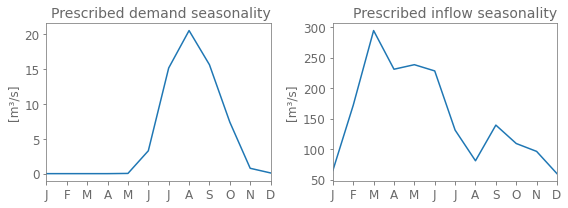

In [48]:
# make plot for jackson lake (upstream of Palisades to check irrigation demand)
ntopo_res = ntopo.where(ntopo['PFAF'] == 31249997, drop=True)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
demand_seas = []
for month in months: demand_seas.append(ntopo_res['H06_D_'+month].values[0])
ax1.plot(np.arange(0,12), demand_seas)
ax1.set_xticks(np.arange(0,12))
ax1.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax1.set_xlim([0,11])
ax1.set_title('Prescribed demand seasonality', loc='right', fontsize=14)
ax1.set_ylabel('[m³/s]')

ax2.plot(np.arange(0,12), inflow_seas)
ax2.set_xticks(np.arange(0,12))
ax2.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax2.set_xlim([0,11])
ax2.set_title('Prescribed inflow seasonality', loc='right', fontsize=14)
ax2.set_ylabel('[m³/s]')
fig.tight_layout()
#fig.suptitle('Jackson Lake')


In [47]:
(ntopo['PFAF'] == 3124997).sum()

<xarray.DataArray 'PFAF' ()>
array(0)